IA & Data science (LU3IN0226) -- 2020-2021
--------
*&copy; Equipe pédagogique: Vincent Guigue, Christophe Marsala, Edoardo Sarti, Olivier Schwander.*


## Projet 2021

### Préparation du notebook


<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

JDAY Achraf

TALEB Rida

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>projet-2021</tt> et rajouter à la suite de <tt>projet-2021</tt> les noms des membres du binômes séparés par un tiret.

Par exemple, pour le binôme Luke Skywalker et Han Solo, le nom de fichier devient `projet2021-Skywalker-Solo`

Penser à sauvegarder fréquemment le fichier en cours de travail :
- soit en cliquant sur l'icône "disquette"
- soit par la combinaison de touches [Ctrl]-S

## Données

Les données vous sont fournies sur le moodle. 
Ces données sont fournies sur Kaggle, ce sont les données *Google Play Store Apps* accessibles à l'adresse https://www.kaggle.com/lava18/google-play-store-apps.

Il est indispensable de lire en détail la page Kaggle pour comprendre à quoi ces données correspondent.

Le compte-rendu a fournir le jour de la dernière séance de TDTME de votre groupe doit comporter:
- un fichier PDF qui correspond à un poster sur lequel sont expliqués les différents problèmes traités, la façon dont ils ont été traités, et les résultats obtenus.
- un notebook par problème traité, vous pouvez traiter autant de problème que vous le souhaitez. Le problème étudié doit être décrit précisément et vous devez impérativement suivre le format ci-dessous.

Bien entendu, le tout sera mis dans un fichier archive (tar.gz ou zip exclusivement) et déposé sur le site Moodle.


Format à suivre:

## Partie 1 - Description du problème

#### Analyse d'une base de données de reviews numérique sur les applications mobile du Google PlayStore ainsi qu'une analyse de sentiments et utilisation d'une base de reviews textuelle afin de prédire les clusters sur l'ensemble des applications gratuites et payantes.

#### Nous avons choisit cette problèmatique en apprentissage non supervisé parce que  nous trouvons qu'il sera intéressant de voir la répartition des avis textuelles individuelles sur l'ensemble des données ainsi que sur les free apps et les paid apps séparement pour trouver des tendances meme psychologique dans la manière dont les utilisateurs évaluent les produits qu'ils utilisents.  

## Partie 2 - Modèle

#### Nous utilisons des modèles d'apprentissage non supervisé que nous avons codé par nous meme, l'algorithme des K-Moyennes, nous avons aussi implémenté des clusterings heatmaps hiérarchiques comme modèles et des algorithmes statistiques notamment le TF-IDF pour adapter la base de données,  tout en changont de paramètres dans plusieurs cas.

## Partie 3 - Code

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns 
color = sns.color_palette()
sns.set(rc={'figure.figsize':(25,15)})

import plotly
# connected=True signifie qu'il téléchargera la dernière version de la bibliothèque javascript de plotly.
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import plotly.figure_factory as ff
import cufflinks as cf


import warnings
warnings.filterwarnings('ignore')

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as classif

# importation de utils
from iads import utils as ut

In [2]:
%load_ext autoreload
%autoreload 2


## Aperçu de l'ensemble de données

In [3]:

df = pd.read_csv('GoogleApps/googleplaystore.csv')

df.drop_duplicates(subset='App', inplace=True)
df = df[df['Android Ver'] != np.nan]
df = df[df['Android Ver'] != 'NaN']
df = df[df['Installs'] != 'Free']
df = df[df['Installs'] != 'Paid']

#print(len(df))

In [4]:
print("Nombre d'applications dans l'ensemble de données : " , len(df))
df.sample(7)

Nombre d'applications dans l'ensemble de données :  9659


App             Category  Rating  \
6314                              The Daily BJ   HEALTH_AND_FITNESS     4.8   
2313                   BioLife Plasma Services              MEDICAL     3.5   
7098  CA Laws 2018 (California Laws and Codes)  BOOKS_AND_REFERENCE     3.9   
4499                             Offroad Car Q               FAMILY     4.1   
6239                  BH - Fitness & Nutrition   HEALTH_AND_FITNESS     NaN   
6948                   Bitcoin BX Thailand PRO              FINANCE     1.7   
1009                                     Fever               EVENTS     4.0   

     Reviews Size    Installs  Type  Price Content Rating             Genres  \
6314      38  24M        500+  Free      0       Everyone   Health & Fitness   
2313     250  23M    100,000+  Free      0       Everyone            Medical   
7098      56  38M      5,000+  Free      0       Everyone  Books & Reference   
4499   24668  40M  1,000,000+  Free      0       Everyone         Simulation   
6239       0  43M          1+  Free      0       Everyone   Health & Fitness   
6948      21  21M        100+  Paid  $4.99       Everyone            Finance   
1009   20611  12M  1,000,000+  Free      0           Teen             Events   

          Last Updated Current Ver   Android Ver  
6314     July 10, 2018         1.1    5.0 and up  
2313      July 9, 2018       1.2.0    4.4 and up  
7098    March 24, 2018        1.17    4.4 and up  
4499    August 4, 2016       1.0.2  2.3.3 and up  
6239      July 4, 2018       4.3.6    4.1 and up  
6948  October 22, 2017         5.0  4.0.3 and up  
1009     July 18, 2018       4.3.6    4.1 and up

## Nettoyage des données
 - Convertir toutes les tailles d'applications en MB
 - Supprimez le '+' de 'Nombre d'installations' pour le rendre numérique.
 - Convertir tous les textes de commentaires en anglais en utilisant la bibliothèque Google Translator.

In [5]:

# - Installs : Remove + and ,

df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '') if '+' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', '') if ',' in str(x) else x)
df['Installs'] = df['Installs'].apply(lambda x: int(x))
#print(type(df['Installs'].values))


In [6]:
# - Size : Remove 'M', Replace 'k' and divide by 10^-3
#df['Size'] = df['Size'].fillna(0)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('Varies with device', 'NaN') if 'Varies with device' in str(x) else x)

df['Size'] = df['Size'].apply(lambda x: str(x).replace('M', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: str(x).replace(',', '') if 'M' in str(x) else x)
df['Size'] = df['Size'].apply(lambda x: float(str(x).replace('k', '')) / 1000 if 'k' in str(x) else x)


df['Size'] = df['Size'].apply(lambda x: float(x))
df['Installs'] = df['Installs'].apply(lambda x: float(x))

df['Price'] = df['Price'].apply(lambda x: str(x).replace('$', '') if '$' in str(x) else str(x))
df['Price'] = df['Price'].apply(lambda x: float(x))

df['Reviews'] = df['Reviews'].apply(lambda x: int(x))
#df['Reviews'] = df['Reviews'].apply(lambda x: 'NaN' if int(x) == 0 else int(x))
#print(df.loc[df.Size == 0.713]) #index = 3384
#df.loc[df.col1 == '']['col2']

# 0 - Free, 1 - Paid
# df['Type'] = pd.factorize(df['Type'])[0]
#print(df.dtypes)

In [7]:
df.sample(7)

App             Category  Rating  \
9042                Tricky Bike Stunt Rider DX               FAMILY     4.4   
7010  Pixyfy: coloring by number coloring book               FAMILY     4.8   
5335                               Al Mayadeen   NEWS_AND_MAGAZINES     4.7   
157                 Spanish English Translator  BOOKS_AND_REFERENCE     4.2   
609   Girls Live Chat - Free Text & Video Chat               DATING     4.8   
7569                     CM S Pen Add-on(ROOT)                TOOLS     3.6   
3124             AT&T Navigator: Maps, Traffic     TRAVEL_AND_LOCAL     3.6   

      Reviews    Size    Installs  Type  Price Content Rating  \
9042       16  45.000       500.0  Free    0.0       Everyone   
7010    22290  13.000    500000.0  Free    0.0       Everyone   
5335    13620   9.000    500000.0  Free    0.0       Everyone   
157     87873     NaN  10000000.0  Free    0.0           Teen   
609       110   4.900     10000.0  Free    0.0     Mature 17+   
7569      373   0.122     10000.0  Free    0.0       Everyone   
3124    32862  14.000  10000000.0  Free    0.0       Everyone   

                    Genres       Last Updated         Current Ver  \
9042  Simulation;Education      July 29, 2018               1.1.1   
7010                Puzzle     August 5, 2018            18.08.05   
5335      News & Magazines     April 16, 2018               2.137   
157      Books & Reference       May 28, 2018  Varies with device   
609                 Dating       July 9, 2018                 8.2   
7569                 Tools  February 24, 2017               1.0.9   
3124        Travel & Local   December 6, 2016    5.10.6.2.8466393   

             Android Ver  
9042          4.0 and up  
7010          4.0 and up  
5335          4.1 and up  
157   Varies with device  
609         4.0.3 and up  
7569          4.1 and up  
3124          4.1 and up

## Analyse de données

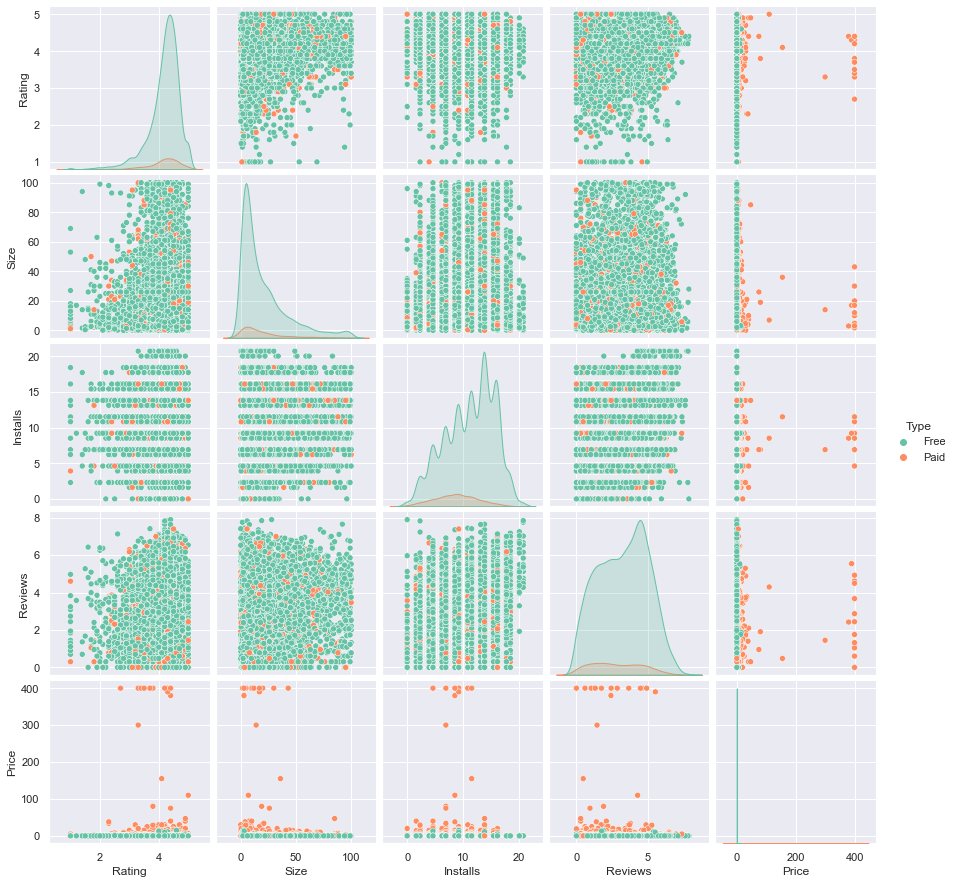

In [8]:
#print(df.dtypes)


x = df['Rating'].dropna()
y = df['Size'].dropna()
z = df['Installs'][df.Installs!=0].dropna()
p = df['Reviews'][df.Reviews!=0].dropna()
t = df['Type'].dropna()
price = df['Price']

p = sns.pairplot(pd.DataFrame(list(zip(x, y, np.log(z), np.log10(p), t, price)), 
                        columns=['Rating','Size', 'Installs', 'Reviews', 'Type', 'Price']), hue='Type', palette="Set2")

       Il s'agit de l'analyse exploratoire de base qui vise à rechercher des modèles ou des relations évidentes entre les caractéristiques.  

## Répartition du marché Android
Quelle catégorie a la plus grande part d'applications (actives) sur le marché ?

In [9]:
number_of_apps_in_category = df['Category'].value_counts().sort_values(ascending=True)

data = [go.Pie(
        labels = number_of_apps_in_category.index,
        values = number_of_apps_in_category.values,
        hoverinfo = 'label+value'
    
)]

plotly.offline.iplot(data, filename='active_category')

- Les applications **Famille** et **Jeux** ont la plus forte prévalence sur le marché. 
- Il est intéressant de noter que les applications **Outils, Business et Médical** sont également en train de rattraper leur retard.

## Note moyenne des applications
Y a-t-il des applications qui fonctionnent très bien ou très mal ?

In [10]:
data = [go.Histogram(
        x = df.Rating,
        xbins = {'start': 1, 'size': 0.1, 'end' :5}
)]

print("Note moyenne de l'application = ", np.mean(df['Rating']))
plotly.offline.iplot(data, filename='overall_rating_distribution')

Note moyenne de l'application =  4.173243045387998


En général, la plupart des applications s'en sortent bien avec une note moyenne de **4,17**.

Décomposons ce résultat et vérifions si certaines catégories ont des performances exceptionnellement bonnes ou mauvaises.

## Classement des applications dans les différentes catégories  - One Way Anova Test (test d'Anova à sens unique)

F_onewayResult(statistic=12.79263715618054, pvalue=2.323280446259348e-20)

La valeur p est extrêmement faible, nous rejetons donc l'hypothèse nulle en faveur de l'hypothèse alternative.



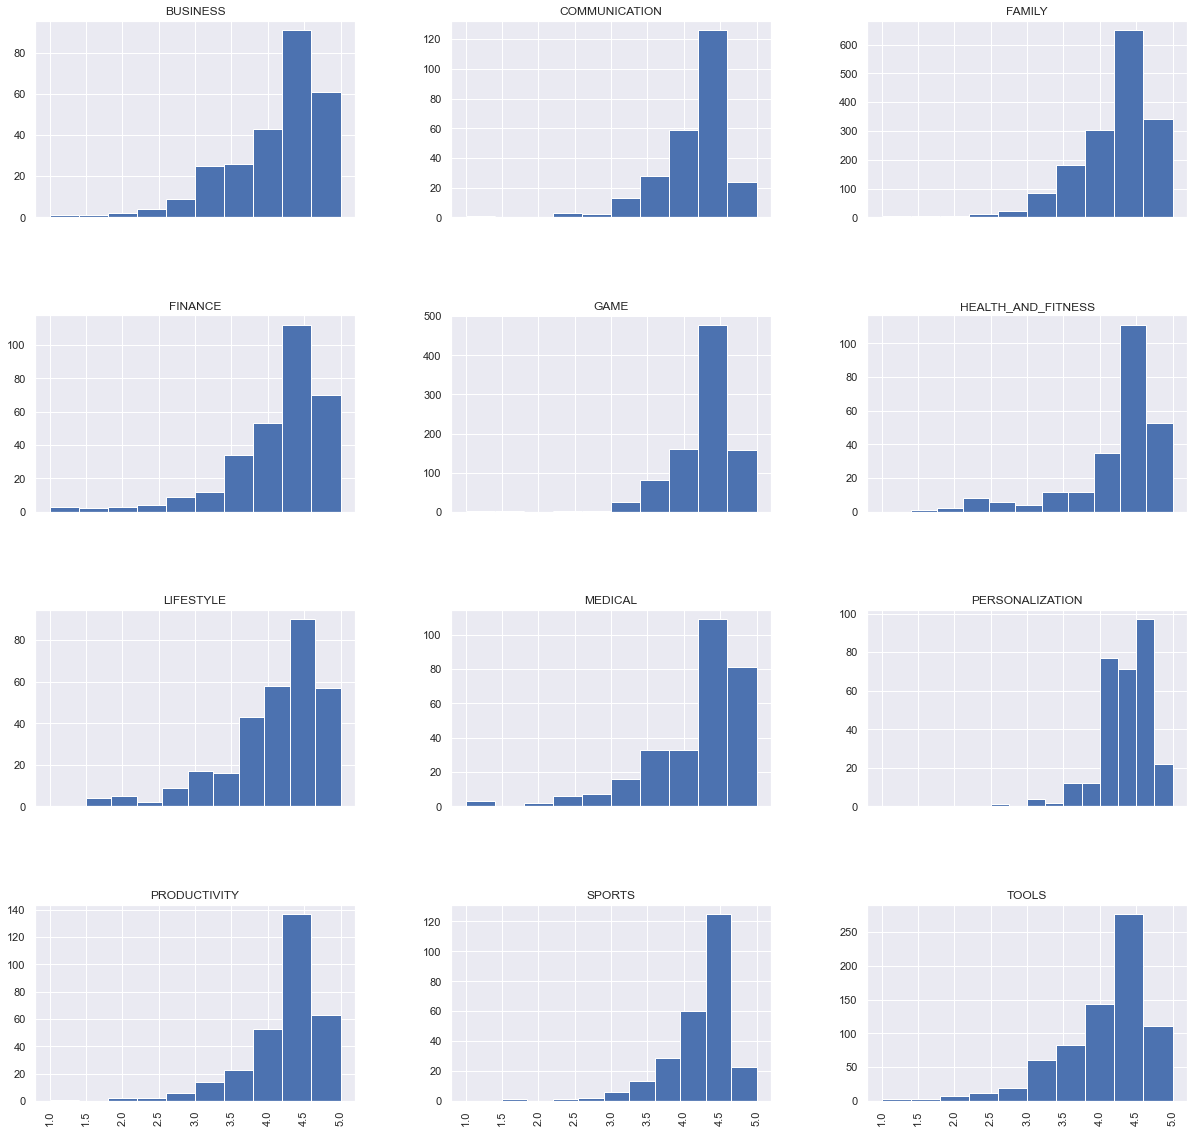

In [11]:
import scipy.stats as stats
f = stats.f_oneway(df.loc[df.Category == 'BUSINESS']['Rating'].dropna(), 
               df.loc[df.Category == 'FAMILY']['Rating'].dropna(),
               df.loc[df.Category == 'GAME']['Rating'].dropna(),
               df.loc[df.Category == 'PERSONALIZATION']['Rating'].dropna(),
               df.loc[df.Category == 'LIFESTYLE']['Rating'].dropna(),
               df.loc[df.Category == 'FINANCE']['Rating'].dropna(),
               df.loc[df.Category == 'EDUCATION']['Rating'].dropna(),
               df.loc[df.Category == 'MEDICAL']['Rating'].dropna(),
               df.loc[df.Category == 'TOOLS']['Rating'].dropna(),
               df.loc[df.Category == 'PRODUCTIVITY']['Rating'].dropna()
              )

print(f)
print("\nLa valeur p est extrêmement faible, nous rejetons donc l'hypothèse nulle en faveur de l'hypothèse alternative.\n")
#temp = df.loc[df.Category.isin(['BUSINESS', 'DATING'])]

groups = df.groupby('Category').filter(lambda x: len(x) > 286).reset_index()
array = groups['Rating'].hist(by=groups['Category'], sharex=True, figsize=(20,20))

                            Le classement moyen des applications dans les différentes catégories est sensiblement différent.

## Catégories les plus performantes

In [12]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 170).reset_index()
#print(type(groups.item.['BUSINESS']))
print('Average rating = ', np.nanmean(list(groups.Rating)))
#print(len(groups.loc[df.Category == 'DATING']))
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 720, len(set(groups.Category)))]


#df_sorted = df.groupby('Category').agg({'Rating':'median'}).reset_index().sort_values(by='Rating', ascending=False)
#print(df_sorted)

layout = {'title' : 'Classement des applications dans les principales catégories',
        'xaxis': {'tickangle':-40},
        'yaxis': {'title': 'Rating'},
          'plot_bgcolor': 'rgb(250,250,250)',
          'shapes': [{
              'type' :'line',
              'x0': -.5,
              'y0': np.nanmean(list(groups.Rating)),
              'x1': 19,
              'y1': np.nanmean(list(groups.Rating)),
              'line': { 'dash': 'dashdot'}
          }]
          }

data = [{
    'y': df.loc[df.Category==category]['Rating'], 
    'type':'violin',
    'name' : category,
    'showlegend':False,
    #'marker': {'color': 'Set2'},
    } for i,category in enumerate(list(set(groups.Category)))]



plotly.offline.iplot({'data': data, 'layout': layout})



Average rating =  4.170026786973072



- Presque toutes les catégories d'applications obtiennent des résultats satisfaisants. Les catégories **Santé et forme physique** et **Livres et référence** produisent les applications de la plus haute qualité avec **50% des applications ayant une note supérieure à 4,5**, ce qui est extrêmement élevé !


- Au contraire, **50% des applications de la catégorie Rencontres ont une note inférieure à la note moyenne**. 


- On trouve également quelques **applications inutiles** dans les catégories **Vie de vie**, **Famille** et **Finance**.


Traduit avec www.DeepL.com/Translator (version gratuite)

# Stratégie de dimensionnement - Léger ou volumineux ?

Quel est l'impact de la taille des applications sur leur classement ?

In [13]:
groups = df.groupby('Category').filter(lambda x: len(x) >= 50).reset_index()

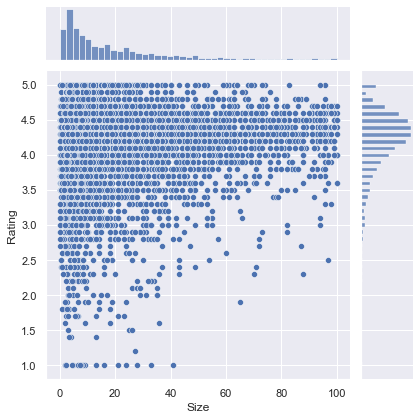

In [14]:
# sns.set_style('ticks')
# fig, ax = plt.subplots()
# fig.set_size_inches(8, 8)
sns.set_style("darkgrid")
ax = sns.jointplot(df['Size'], df['Rating'])
#ax.set_title('Rating Vs Size')

La plupart des applications les mieux notées ont une taille optimale comprise entre **~2MB et ~40MB** - ni trop légères ni trop lourdes.

In [15]:

c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(list(set(groups.Category))))]

subset_df = df[df.Size > 40]
groups_temp = subset_df.groupby('Category').filter(lambda x: len(x) >20)

# for category in enumerate(list(set(groups_temp.Category))):
#     print (category)

data = [{
    'x': groups_temp.loc[subset_df.Category==category[1]]['Rating'], 
    'type':'scatter',
    'y' : subset_df['Size'],
    'name' : str(category[1]),
    'mode' : 'markers',
    'showlegend': True,
    #'marker': {'color':c[i]}
    #'text' : df['rating'],
    } for category in enumerate(['GAME', 'FAMILY'])]


layout = {'title':"Classement par rapport à la taille", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

# heavy_categories = [ 'ENTERTAINMENT', 'MEDICAL', 'DATING']

# data = [{
#     'x': groups.loc[df.Category==category]['Rating'], 
#     'type':'scatter',
#     'y' : df['Size'],
#     'name' : category,
#     'mode' : 'markers',
#     'showlegend': True,
#     #'text' : df['rating'],
#     } for category in heavy_categories]

La plupart des applications volumineuses ( >50 Mo) appartiennent à la catégorie **Jeux** et **Famille**. Malgré cela, ces applications encombrantes sont assez bien notées, ce qui indique qu'elles sont encombrantes dans un but précis.

# Stratégie de tarification - Gratuit ou payant ?
Comment les prix des applications influencent-ils leur classement ?

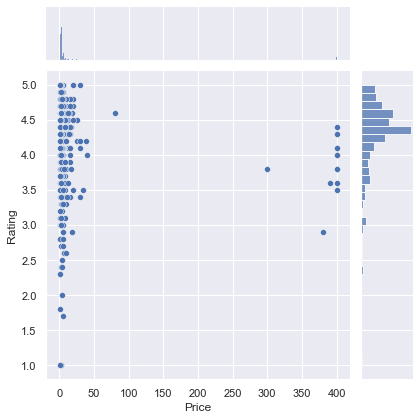

In [16]:
paid_apps = df[df.Price>0]
p = sns.jointplot( "Price", "Rating", paid_apps)

La plupart des applications les mieux notées ont un prix optimal compris entre ** ~1\$ et ~30\$ **. Il n'y a que très peu d'applications dont le prix est supérieur à 20 $.

## Tendance actuelle des prix - Comment fixer le prix de votre application ?

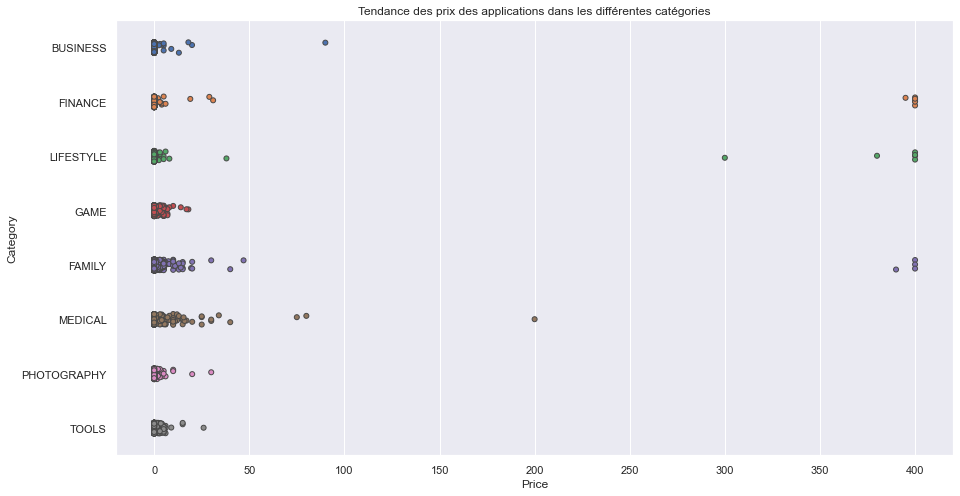

In [17]:
subset_df = df[df.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY', 'MEDICAL', 'TOOLS', 'FINANCE',
                                 'LIFESTYLE','BUSINESS'])]
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
p = sns.stripplot(x="Price", y="Category", data=subset_df, jitter=True, linewidth=1)
title = ax.set_title('Tendance des prix des applications dans les différentes catégories')


**Choquant...Des applications à un prix supérieur à 250\$ ! !! ** Examinons rapidement ce que sont ces applications "poubelles".

In [18]:
df[['Category', 'App']][df.Price > 200]

Category                                App
4197     FAMILY             most expensive app (H)
4362  LIFESTYLE                         💎 I'm rich
4367  LIFESTYLE           I'm Rich - Trump Edition
5351  LIFESTYLE                          I am rich
5354     FAMILY                     I am Rich Plus
5355  LIFESTYLE                      I am rich VIP
5356    FINANCE                  I Am Rich Premium
5357  LIFESTYLE                I am extremely Rich
5358    FINANCE                         I am Rich!
5359    FINANCE                 I am rich(premium)
5362     FAMILY                      I Am Rich Pro
5364    FINANCE     I am rich (Most expensive app)
5366     FAMILY                          I Am Rich
5369    FINANCE                          I am Rich
5373    FINANCE                 I AM RICH PRO PLUS
9917    FINANCE                        Eu Sou Rico
9934  LIFESTYLE  I'm Rich/Eu sou Rico/أنا غني/我很有錢

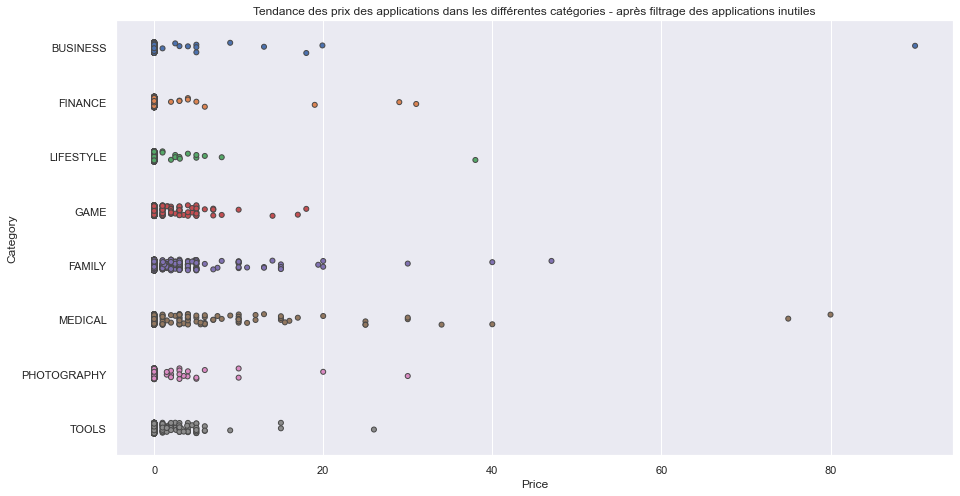

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
subset_df_price = subset_df[subset_df.Price<100]
p = sns.stripplot(x="Price", y="Category", data=subset_df_price, jitter=True, linewidth=1)
title = ax.set_title('Tendance des prix des applications dans les différentes catégories - après filtrage des applications inutiles')

- De toute évidence, les applications médicales et familiales sont les plus chères. Certaines applications médicales vont même jusqu'à 80$.


- Le prix de toutes les autres applications est inférieur à 30 $.


- Étonnamment, **toutes les applications de jeux ont un prix raisonnable inférieur à 20\$.**

## Répartition des applications payantes et gratuites par catégorie

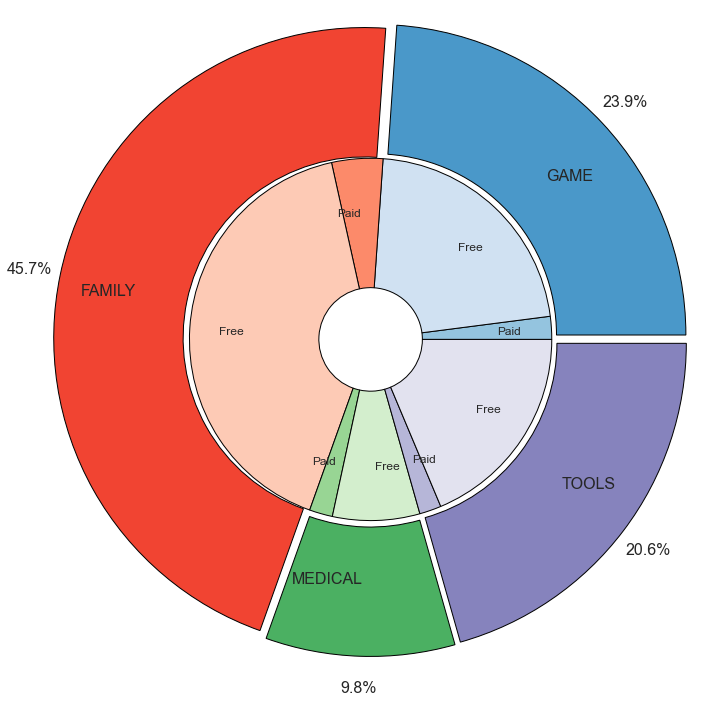

In [20]:
# Stacked bar graph for top 5-10 categories - Ratio of paid and free apps
#fig, ax = plt.subplots(figsize=(15,10))

new_df = df.groupby(['Category', 'Type']).agg({'App' : 'count'}).reset_index()
#print(new_df)

# outer_group_names = df['Category'].sort_values().value_counts()[:5].index
# outer_group_values = df['Category'].sort_values().value_counts()[:5].values

outer_group_names = ['GAME', 'FAMILY', 'MEDICAL', 'TOOLS']
outer_group_values = [len(df.App[df.Category == category]) for category in outer_group_names]

a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]


inner_group_names = ['Paid', 'Free'] * 4
inner_group_values = []
#inner_colors = ['#58a27c','#FFD433']


for category in outer_group_names:
    for t in ['Paid', 'Free']:
        x = new_df[new_df.Category == category]
        try:
            #print(x.App[x.Type == t].values[0])
            inner_group_values.append(int(x.App[x.Type == t].values[0]))
        except:
            #print(x.App[x.Type == t].values[0])
            inner_group_values.append(0)

explode = (0.025,0.025,0.025,0.025)
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, texts, _ = ax.pie(outer_group_values, radius=1.2, labels=outer_group_names, autopct='%1.1f%%', pctdistance=1.1,
                                 labeldistance= 0.75,  explode = explode, colors=[a(0.6), b(0.6), c(0.6), d(0.6)], textprops={'fontsize': 16})
plt.setp( mypie, width=0.5, edgecolor='black')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(inner_group_values, radius=1.2-0.5, labels=inner_group_names, labeldistance= 0.7, 
                   textprops={'fontsize': 12}, colors = [a(0.4), a(0.2), b(0.4), b(0.2), c(0.4), c(0.2), d(0.4), d(0.2)])
plt.setp( mypie2, width=0.5, edgecolor='black')
plt.margins(0,0)
 
# show it
plt.tight_layout()
plt.show()



#ax = sns.countplot(x="Category", hue="Type", data=new_df)

#df.groupby(['Category', 'Type']).count()['App'].unstack().plot(kind='bar', stacked=True, ax=ax)
#ylabel = plt.ylabel('Number of apps')



                        Répartition des applications gratuites et payantes dans les principales catégories

## Les applications payantes sont-elles téléchargées autant que les applications gratuites ?

In [21]:
trace0 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Paid']),
    name = 'Paid',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )

)
trace1 = go.Box(
    y=np.log10(df['Installs'][df.Type=='Free']),
    name = 'Free',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
layout = go.Layout(
    title = "Number of downloads of paid apps Vs free apps",
    yaxis= {'title': 'Number of downloads (log-scaled)'}
)
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

**Les applications payantes ont un nombre de téléchargements relativement plus faible que les applications gratuites**, mais ce n'est pas si mal.

## Comment la taille des applications payantes et des applications gratuites varie-t-elle ?

In [22]:
temp_df = df[df.Type == 'Paid']
temp_df = temp_df[temp_df.Size > 5]
#type_groups = df.groupby('Type')

data = [{
    #'x': type_groups.get_group(t)['Rating'], 
    'x' : temp_df['Rating'],
    'type':'scatter',
    'y' : temp_df['Size'],
    #'name' : t,
    'mode' : 'markers',
    #'showlegend': True,
    'text' : df['Size'],
    } for t in set(temp_df.Type)]


layout = {'title':"Classement par rapport à la taille", 
          'xaxis': {'title' : 'Rating'},
          'yaxis' : {'title' : 'Size (in MB)'},
         'plot_bgcolor': 'rgb(0,0,0)'}

plotly.offline.iplot({'data': data, 'layout': layout})

- La majorité des applications payantes bien notées sont de petite taille**, ce qui signifie que la plupart des applications payantes sont conçues et développées pour répondre à des fonctionnalités spécifiques et ne sont donc pas volumineuses.


- Les utilisateurs préfèrent payer pour des applications légères**. Une application payante qui est encombrante risque de ne pas être performante sur le marché.


## Explorer les corrélations

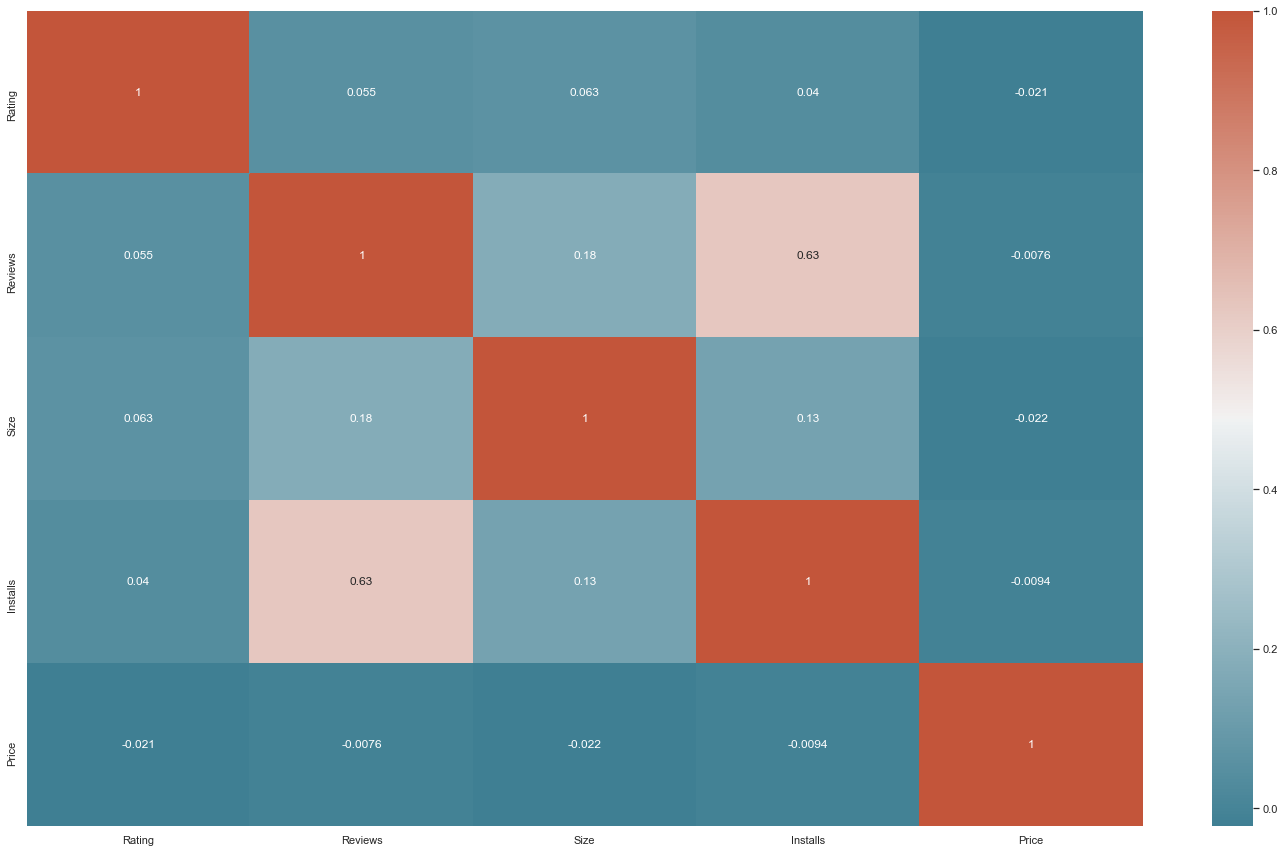

In [23]:
#df['Installs'].corr(df['Reviews'])#df['Insta 
#print(np.corrcoef(l, rating))

corrmat = df.corr()
#f, ax = plt.subplots()
p =sns.heatmap(corrmat, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

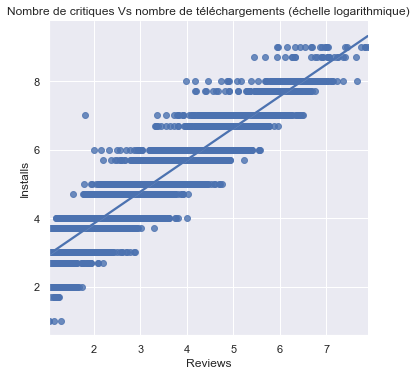

In [24]:
df_copy = df.copy()

df_copy = df_copy[df_copy.Reviews > 10]
df_copy = df_copy[df_copy.Installs > 0]

df_copy['Installs'] = np.log10(df['Installs'])
df_copy['Reviews'] = np.log10(df['Reviews'])

sns.lmplot("Reviews", "Installs", data=df_copy)
ax = plt.gca()
_ = ax.set_title('Nombre de critiques Vs nombre de téléchargements (échelle logarithmique)')

**Il existe une corrélation positive modérée de 0,63 entre le nombre d'évaluations et le nombre de téléchargements**, ce qui signifie que les clients ont tendance à télécharger davantage une application donnée si celle-ci a été évaluée par un grand nombre de personnes. 

Cela signifie également que les utilisateurs actifs qui téléchargent une application laissent généralement un avis ou un commentaire. 

Par conséquent, faire évaluer votre application par un plus grand nombre de personnes peut être une bonne idée pour augmenter la pénétration de votre application sur le marché !


## Analyse basique des sentiments - Avis des utilisateurs 

In [25]:
reviews_df = pd.read_csv('GoogleApps/googleplaystore_user_reviews.csv')

In [26]:
reviews_df=reviews_df.dropna()
reviews=reviews_df['Translated_Review']

In [27]:
#Stop words et Lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

Stop=set(stopwords.words('english'))
WrdLem=WordNetLemmatizer()
print(Stop)

{'such', 'hers', 'down', 'they', 't', "you've", 'where', "shouldn't", 'once', 'd', 'when', 'this', 'from', "didn't", 'himself', "wouldn't", 'on', "isn't", 'haven', 'her', "mightn't", 'shouldn', 'through', 'while', "doesn't", 'won', 'over', 'into', 'didn', 'were', 'can', 'aren', 'most', 'nor', 'his', 'ain', 's', 'he', 'do', 'then', 'out', 'those', 'be', 'needn', 'herself', 'we', 'as', 'doing', 'all', 'who', 'not', 'because', 'itself', 'll', 'doesn', 'before', 'yours', 'whom', 'weren', 'above', 'wouldn', "you'll", 'had', 'below', "won't", 'a', 'about', 'too', 'its', 'my', "it's", 'of', 'our', "should've", 'is', 'so', "weren't", 'their', 'me', 'between', "mustn't", "you're", 'did', 'hasn', 'are', 'only', 'own', 'isn', 'and', 'very', 'couldn', 'after', 'there', 'same', 'am', 'has', "you'd", 'to', 'few', "needn't", 'if', 'will', 'mightn', 'that', 've', 'hadn', 'further', 'these', "shan't", "don't", 'but', 'o', 'some', 'having', 'off', 'themselves', 'any', 'what', 'each', 'under', "wasn't", 

In [28]:
#Nettoyage des reviews (suppression des balises html, de la ponctuation, des lemmatisations)

Cleaned_sent=[]
for sent in reviews:
    r1=[]
    sent=ut.cleanhtml(sent)
    sent=ut.cleanpunc(sent)
    sent=sent.lower()
    for  word in sent.split():
        if ((word.isalpha()) & (len(word)>2)):
            if word not in Stop:
                w=WrdLem.lemmatize(word)
                r1.append(w)
            else:
                continue
        else:
            continue
    str1 = (" ".join(r1))        
     
    Cleaned_sent.append(str1)

reviews_df['Cleaned_text']=Cleaned_sent
reviews_df.head(5) 

App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   
5  10 Best Foods for You                                           Best way   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  \
0  Positive                1.00                0.533333   
1  Positive                0.25                0.288462   
3  Positive                0.40                0.875000   
4  Positive                1.00                0.300000   
5  Positive                1.00                0.300000   

                                        Cleaned_text  
0  like eat delicious food thats cooking food cas...  
1         help eating healthy exercise regular basis  
3          work great especially going grocery store  
4                                          best idea  
5                                           best way

In [29]:
merged_df = pd.merge(df, reviews_df, on = "App", how = "inner")
merged_df = merged_df.dropna(subset=['Sentiment', 'Cleaned_text'])

In [30]:
grouped_sentiment_category_count = merged_df.groupby(['Category', 'Sentiment']).agg({'App': 'count'}).reset_index()
grouped_sentiment_category_sum = merged_df.groupby(['Category']).agg({'Sentiment': 'count'}).reset_index()

new_df = pd.merge(grouped_sentiment_category_count, grouped_sentiment_category_sum, on=["Category"])
#print(new_df)
new_df['Sentiment_Normalized'] = new_df.App/new_df.Sentiment_y
new_df = new_df.groupby('Category').filter(lambda x: len(x) ==3)
# new_df = new_df[new_df.Category.isin(['HEALTH_AND_FITNESS', 'GAME', 'FAMILY', 'EDUCATION', 'COMMUNICATION', 
#                                      'ENTERTAINMENT', 'TOOLS', 'SOCIAL', 'TRAVEL_AND_LOCAL'])]
new_df

trace1 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[::3][6:-5],
    name='Negative',
    marker=dict(color = 'rgb(209,49,20)')
)

trace2 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[1::3][6:-5],
    name='Neutral',
    marker=dict(color = 'rgb(49,130,189)')
)

trace3 = go.Bar(
    x=list(new_df.Category[::3])[6:-5],
    y= new_df.Sentiment_Normalized[2::3][6:-5],
    name='Positive',
    marker=dict(color = 'rgb(49,189,120)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Analyse des sentiments',
    barmode='stack',
    xaxis = {'tickangle': -45},
    yaxis = {'title': 'Fraction of reviews'}
)

fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot({'data': data, 'layout': layout})

- Les applications **Santé et Fitness** sont les plus performantes, avec plus de **85% d'avis positifs**.


- Au contraire, de nombreuses applications **Jeux et activités sociales** obtiennent de mauvais résultats, avec **50% d'avis positifs et 50% d'avis négatifs**.

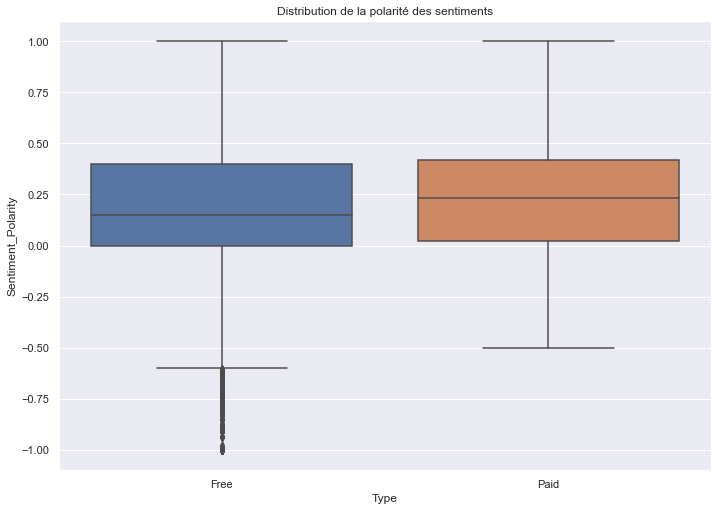

In [31]:
#merged_df.loc[merged_df.Type=='Free']['Sentiment_Polarity']
sns.set_style('ticks')
sns.set_style("darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.boxplot(x='Type', y='Sentiment_Polarity', data=merged_df)
title = ax.set_title('Distribution de la polarité des sentiments')

- Les applications gratuites font l'objet de nombreux commentaires sévères**, qui sont indiqués comme des valeurs aberrantes sur l'axe des Y négatifs. 

- Les utilisateurs sont plus indulgents et plus tolérants lorsqu'ils évaluent des applications payantes - choix modéré des mots - et ne sont jamais extrêmement négatifs lorsqu'ils évaluent une application payante. 

## WORDCLOUD - Un coup d'œil rapide sur les critiques


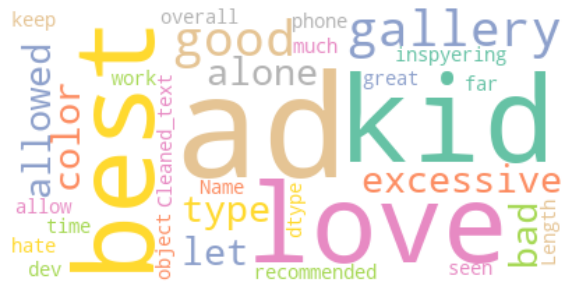

In [32]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", max_words=200, colormap="Set2")
wc1 = WordCloud(background_color="white", max_words=200, colormap="Set2")
# generate word cloud

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop = stop + ['app', 'APP' ,'ap', 'App', 'apps', 'application', 'browser', 'website', 'websites', 'chrome', 'click', 'web', 'ip', 'address',
            'files', 'android', 'browse', 'service', 'use', 'one', 'download', 'email', 'Launcher']

#merged_df = merged_df.dropna(subset=['Translated_Review'])
merged_df['Cleaned_text'] = merged_df['Cleaned_text'].apply(lambda x: " ".join(x for x in str(x).split(' ') if x not in stop))
#print(any(merged_df.Translated_Review.isna()))
merged_df.Translated_Review = merged_df.Translated_Review.apply(lambda x: x if 'app' not in x.split(' ') else np.nan)
merged_df.dropna(subset=['Cleaned_text'], inplace=True)


free = merged_df.loc[merged_df.Type=='Free']['Cleaned_text'].apply(lambda x: '' if x=='nan' else x)
wc.generate(''.join(str(free)))
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

   ** FREE APPS **
> 
**Negative words: ads, bad, hate**
>
**Positive words: good, love, best, great**

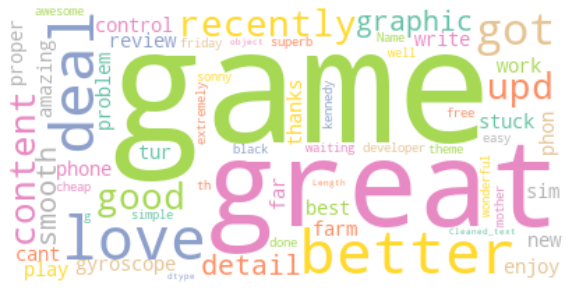

In [33]:
paid =merged_df.loc[merged_df.Type=='Paid']['Cleaned_text'].apply(lambda x: '' if x=='nan' else x)
wc1.generate(''.join(str(paid)))
plt.figure(figsize=(10, 10))
plt.imshow(wc1, interpolation='bilinear')
plt.axis("off")
plt.show()

   ** PAID APPS **
> 
**Negative words: malware, problem**
>
**Positive words: great, love, easy**

## Partie 4 - Protocole expérimental

In [34]:
merged_df['Cleaned_text'].head(1000)

0      kid excessive ad type ad allowed let alone kid
1                                                 bad
2                                                like
3                               love color inspyering
4                                                hate
                            ...                      
995                                        think good
996                                       simple nice
997                                              good
998                                       really love
999                               dress well designed
Name: Cleaned_text, Length: 1000, dtype: object

In [35]:
merged_df['App'].head(1000)

0                 Coloring book moana
1                 Coloring book moana
2                 Coloring book moana
3                 Coloring book moana
4                 Coloring book moana
                    ...              
995    Dresses Ideas & Fashions +3000
996    Dresses Ideas & Fashions +3000
997    Dresses Ideas & Fashions +3000
998    Dresses Ideas & Fashions +3000
999    Dresses Ideas & Fashions +3000
Name: App, Length: 1000, dtype: object

In [36]:
 pd_tfidf = ut.TFIDF(merged_df['Cleaned_text'],0.01,0.75)

#### Clustering Hièrarchique 

#### Test avec distance Euclidienne

In [37]:
distance_euclidienne = ut.distance_euclidienne(pd.DataFrame(pd_tfidf.head(20)))

In [38]:
distance_euclidienne1 = ut.distance_euclidienne(pd.DataFrame(pd_tfidf.head(50)))

#### Test avec distance Cosine

In [39]:
distance_cosine = ut.distance_cosine(pd.DataFrame(pd_tfidf.head(20)))

In [40]:
distance_cosine1 = ut.distance_cosine(pd.DataFrame(pd_tfidf.head(50)))

#### Test avec distance Manhattan

In [41]:
distance_manhattan = ut.distance_manhattan(pd.DataFrame(pd_tfidf.head(20)))

In [42]:
distance_manhattan1 = ut.distance_manhattan(pd.DataFrame(pd_tfidf.head(50)))

#### Test avec similarité cosayne

In [43]:
similariter_cosayne = ut.similariter_cosayne(pd.DataFrame(pd_tfidf.head(20)))

In [44]:
similariter_cosayne1 = ut.similariter_cosayne(pd.DataFrame(pd_tfidf.head(50)))

#### K Means

In [45]:
from sklearn.decomposition import PCA
pca = PCA(2)
dfkmeansA = pca.fit_transform(pd_tfidf)

In [46]:
les_centresA, l_affectationA = ut.kmoyennes(2, dfkmeansA, 0.05, 100)

Sélectionnés:  [[-0.03463722679934431, -0.07190453826216824], [-0.07952211302082125, -0.006960657225985549]]
iteration  0 Inertie : 1368.5653523057363 Difference:  84.01675264033429
iteration  1 Inertie : 1284.548599665402 Difference:  11.106636738403722
iteration  2 Inertie : 1273.4419629269983 Difference:  2.5373366937194533
iteration  3 Inertie : 1270.9046262332788 Difference:  0.8449580044350569
iteration  4 Inertie : 1270.0596682288437 Difference:  0.14396800221311423
iteration  5 Inertie : 1269.9157002266306 Difference:  0.03902366540773983


In [47]:
les_centresA1, l_affectationA1 = ut.kmoyennes(3, dfkmeansA, 0.05, 100)

Sélectionnés:  [[-0.04475696740983462, -0.06462800843625008], [-0.034249915115317164, -0.048854021452412376], [-0.02275744032340565, -0.06604646476137847]]
iteration  0 Inertie : 1302.313262034494 Difference:  638.7819983673113
iteration  1 Inertie : 663.5312636671828 Difference:  126.536022997327
iteration  2 Inertie : 536.9952406698558 Difference:  35.61323507223369
iteration  3 Inertie : 501.3820055976221 Difference:  10.000794773958546
iteration  4 Inertie : 491.38121082366354 Difference:  2.252791576373852
iteration  5 Inertie : 489.1284192472897 Difference:  0.7829133301607953
iteration  6 Inertie : 488.3455059171289 Difference:  0.3412636259544115
iteration  7 Inertie : 488.0042422911745 Difference:  0.09153370780569503
iteration  8 Inertie : 487.9127085833688 Difference:  0.040398415563686285


In [48]:
les_centresA2, l_affectationA2 = ut.kmoyennes(10, dfkmeansA, 0.05, 100)

Sélectionnés:  [[0.1717666864868115, -0.03968450478868423], [-0.03205472544802638, -0.06296279049379493], [-0.1238868118293766, -0.22448203638878653], [-0.07310895438005141, -0.13924025020058217], [-0.044643242931944854, -0.06518516378129424], [-0.05861719722565854, -0.11865661850306448], [-0.024867176879201862, -0.05667323384083552], [-0.02816575138760226, -0.08552965809917566], [-0.02816739520109574, -0.07201193180919337], [0.6876107506038325, 0.48527749194037356]]
iteration  0 Inertie : 654.1249372687993 Difference:  320.3340887457679
iteration  1 Inertie : 333.7908485230314 Difference:  53.6502873671339
iteration  2 Inertie : 280.1405611558975 Difference:  42.14593239210353
iteration  3 Inertie : 237.99462876379397 Difference:  36.18166259444692
iteration  4 Inertie : 201.81296616934705 Difference:  21.63135607466495
iteration  5 Inertie : 180.1816100946821 Difference:  10.925134988326704
iteration  6 Inertie : 169.2564751063554 Difference:  6.1567671994855
iteration  7 Inertie : 1

### Apps Payantes

In [49]:
merged_df.loc[merged_df.Type=='Paid']['Cleaned_text']=paid

In [50]:
 pd_tfidf1 = ut.TFIDF(merged_df.loc[merged_df.Type=='Paid']['Cleaned_text'],0.0,0.7)

#### Clustering Hièrarchique

In [51]:
similariter_cosayneA = ut.similariter_cosayne(pd.DataFrame(pd_tfidf1.head(20)))

#### K-MEANS

In [52]:
dfkmeansB = pca.fit_transform(pd_tfidf1)

In [53]:
les_centresB, l_affectationB = ut.kmoyennes(2, dfkmeansB, 0.05, 100)

Sélectionnés:  [[-0.1210106276078508, 0.04534076021897079], [-0.06356287368003294, 0.0018570460163515224]]
iteration  0 Inertie : 14.37681052329315 Difference:  1.8646567992313763
iteration  1 Inertie : 12.512153724061774 Difference:  2.770720568912319
iteration  2 Inertie : 9.741433155149455 Difference:  1.4795372206270692
iteration  3 Inertie : 8.261895934522386 Difference:  0.196481823173567
iteration  4 Inertie : 8.065414111348819 Difference:  0.020275062799182564


### Apps gratuites

In [54]:
merged_df.loc[merged_df.Type=='Free']['Cleaned_text']=free

In [55]:
 pd_tfidf2 = ut.TFIDF(merged_df.loc[merged_df.Type=='Free']['Cleaned_text'],0,0.7)

#### Clustering Hièrarchique

In [56]:
similariter_cosayneB = ut.similariter_cosayne(pd.DataFrame(pd_tfidf2.tail(20)))

#### K-MEANS


In [57]:
dfkmeansC = pca.fit_transform(pd_tfidf2)

In [58]:
les_centresC, l_affectationC = ut.kmoyennes(2, dfkmeansC, 0.05, 100)

Sélectionnés:  [[-0.03056338027210355, -0.020169942470126743], [-0.03830315048482142, -0.03691958935368165]]
iteration  0 Inertie : 1046.5763575146127 Difference:  163.43829048282373
iteration  1 Inertie : 883.138067031789 Difference:  79.56581338779449
iteration  2 Inertie : 803.5722536439945 Difference:  57.65484534851714
iteration  3 Inertie : 745.9174082954773 Difference:  40.943842657769665
iteration  4 Inertie : 704.9735656377077 Difference:  25.16014495655918
iteration  5 Inertie : 679.8134206811485 Difference:  10.592762491260032
iteration  6 Inertie : 669.2206581898885 Difference:  2.5228831023551948
iteration  7 Inertie : 666.6977750875333 Difference:  0.7286217751841377
iteration  8 Inertie : 665.9691533123491 Difference:  0.3097521847846565
iteration  9 Inertie : 665.6594011275645 Difference:  0.11762476751766826
iteration  10 Inertie : 665.5417763600468 Difference:  0.021655017589182535


## Partie 5 - Résultats

### Sur l'ensemble des données

#### Clustering Hièrarchique

#### Test avec distance Euclidienne

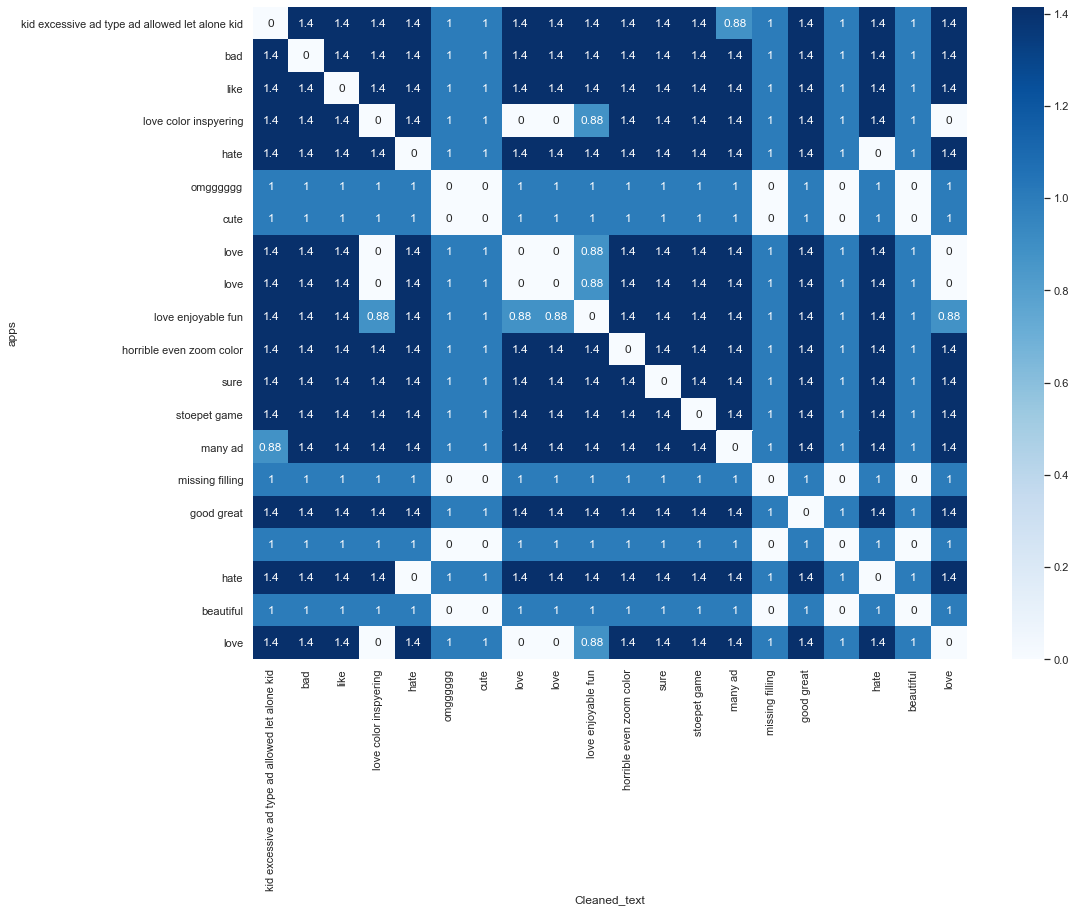

In [59]:
ut.afficheHeatmap(distance_euclidienne,merged_df['Cleaned_text'].head(20))

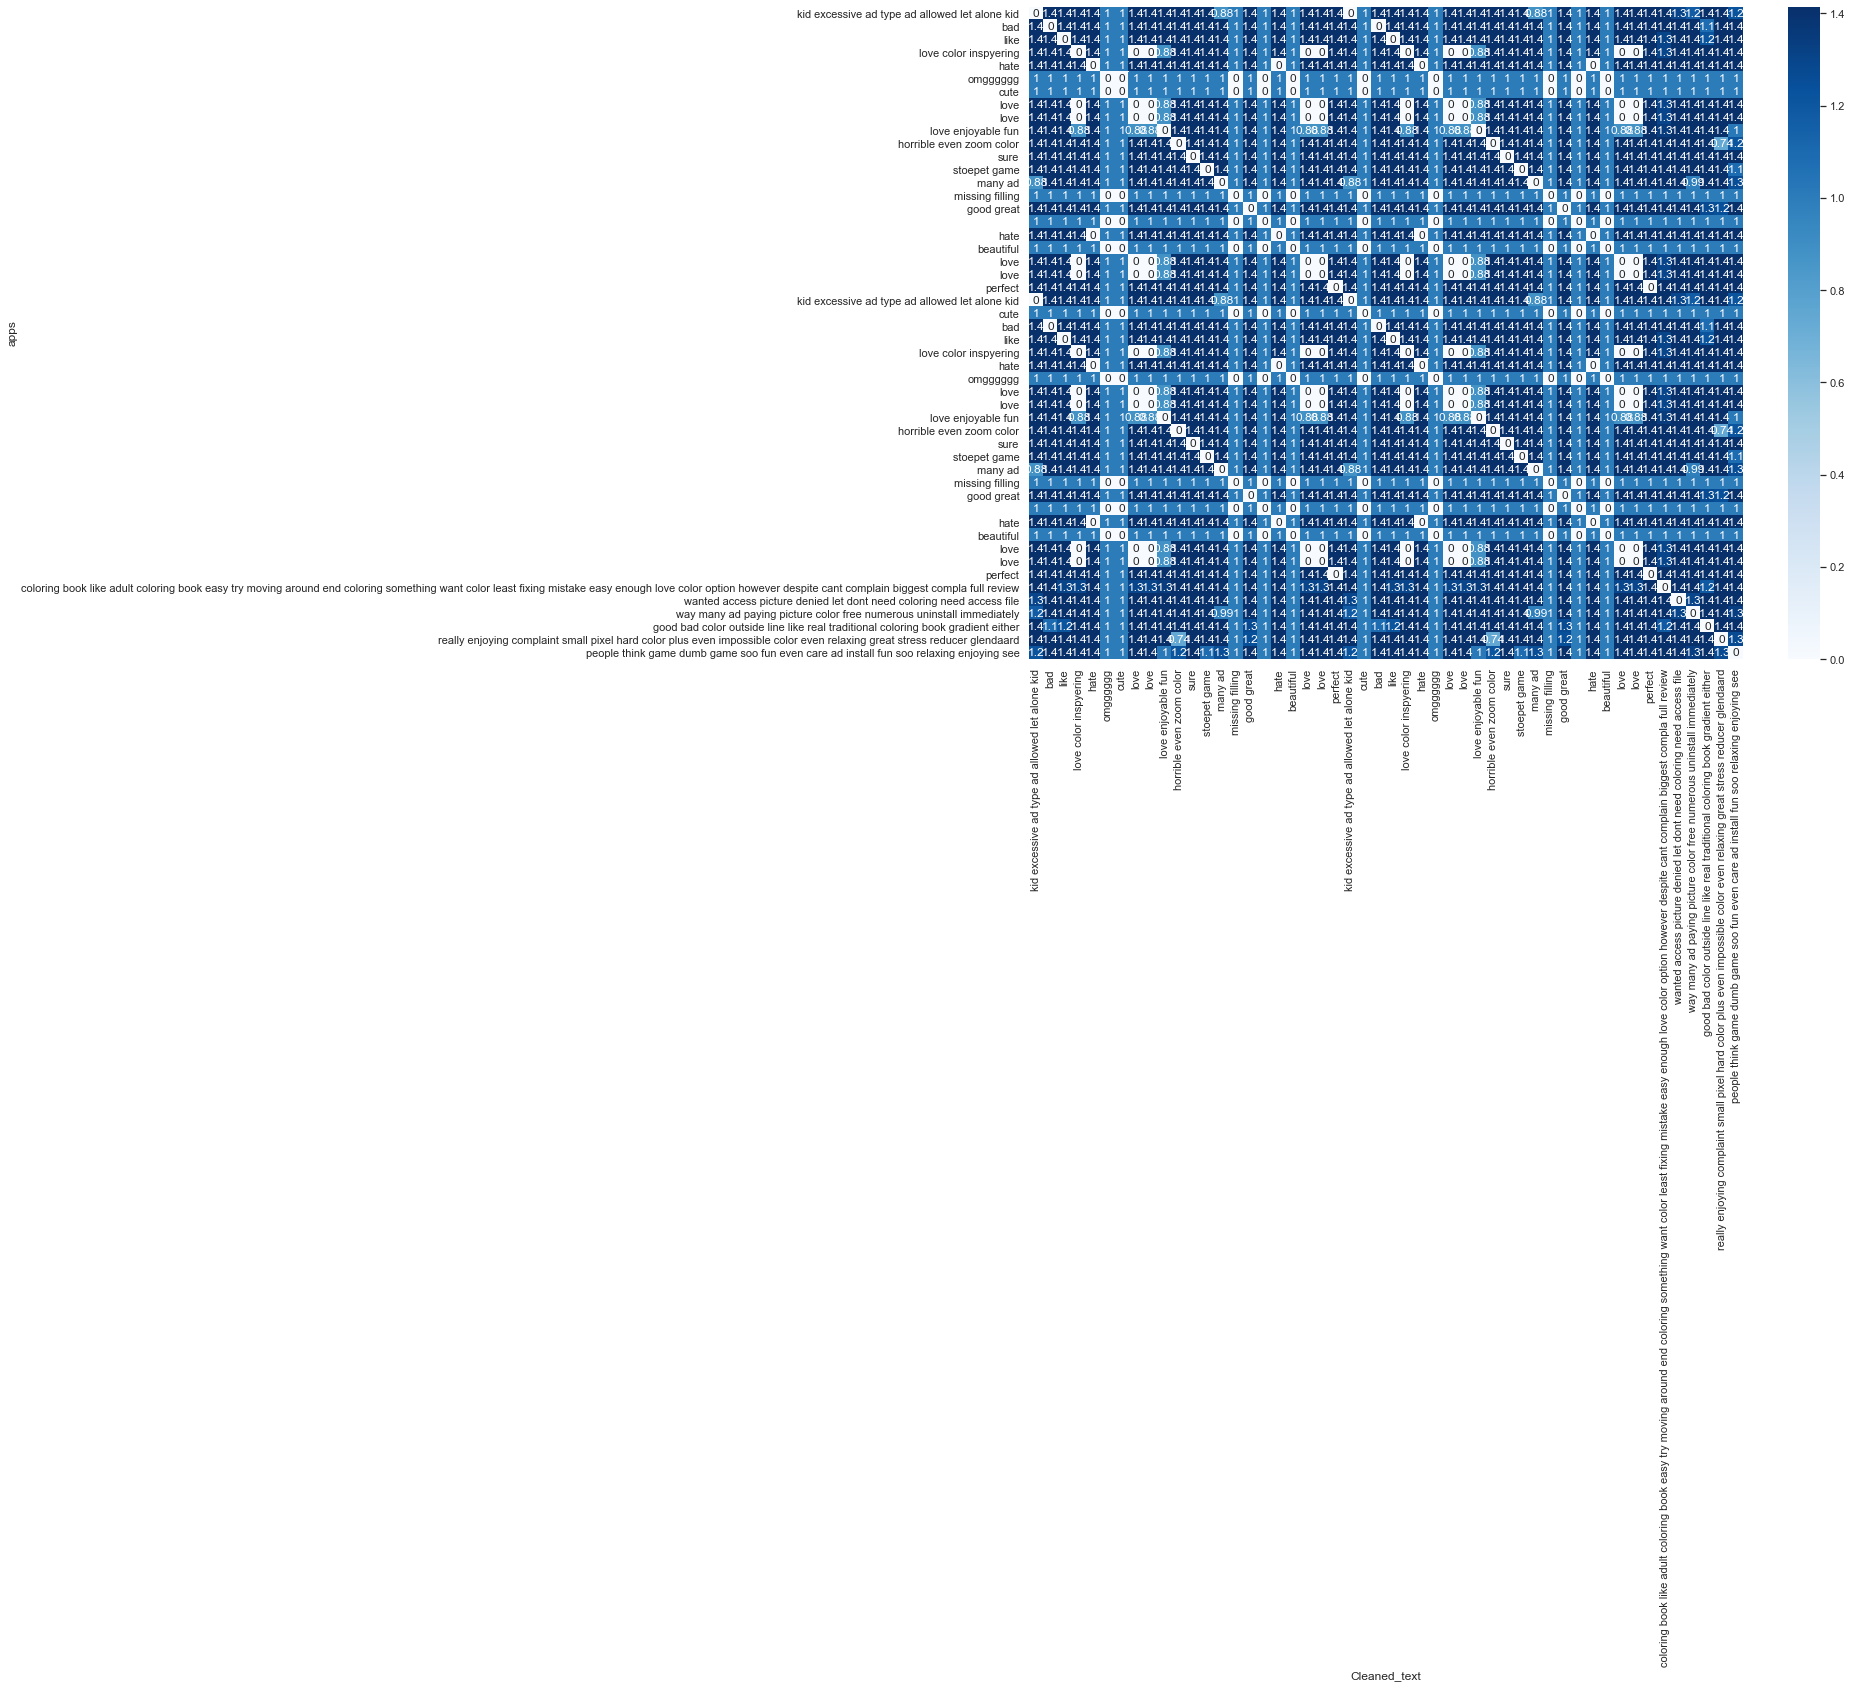

In [60]:
ut.afficheHeatmap(distance_euclidienne1,merged_df['Cleaned_text'].head(50))

#### Test avec distance Cosine

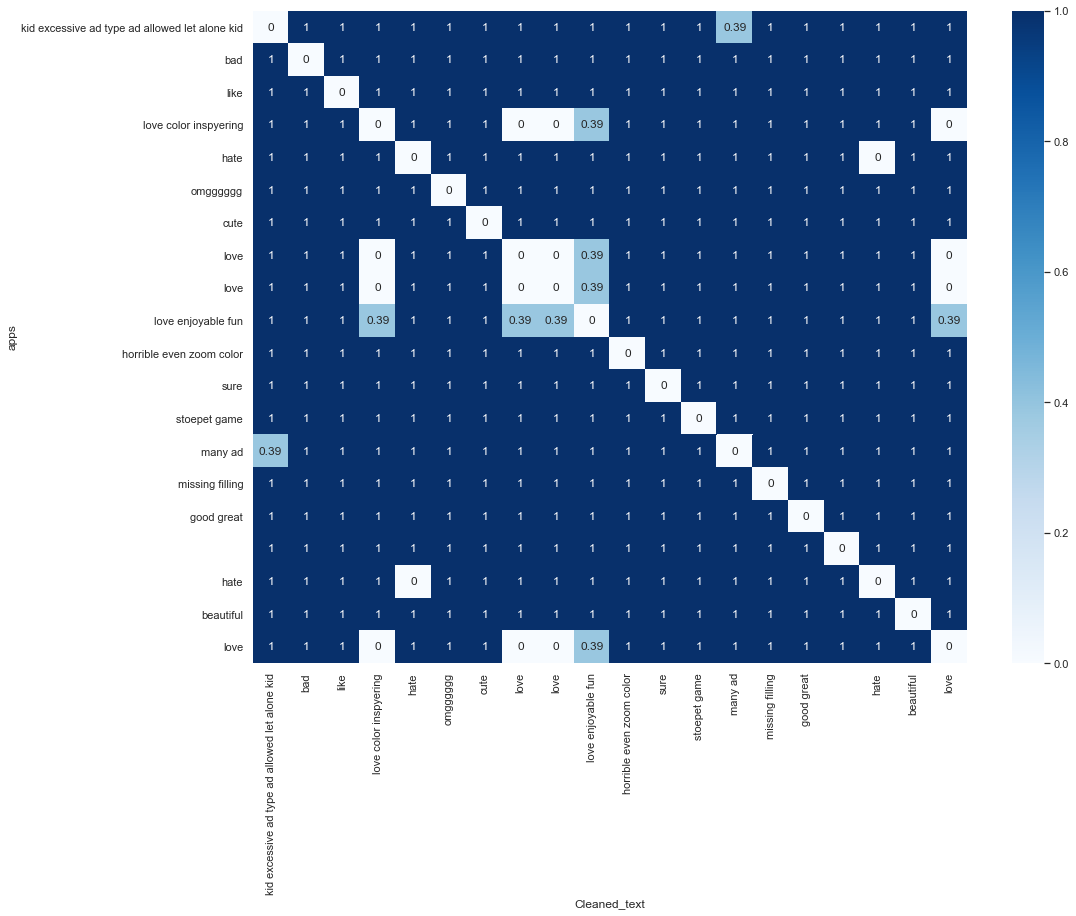

In [61]:
ut.afficheHeatmap(distance_cosine,merged_df['Cleaned_text'].head(20))

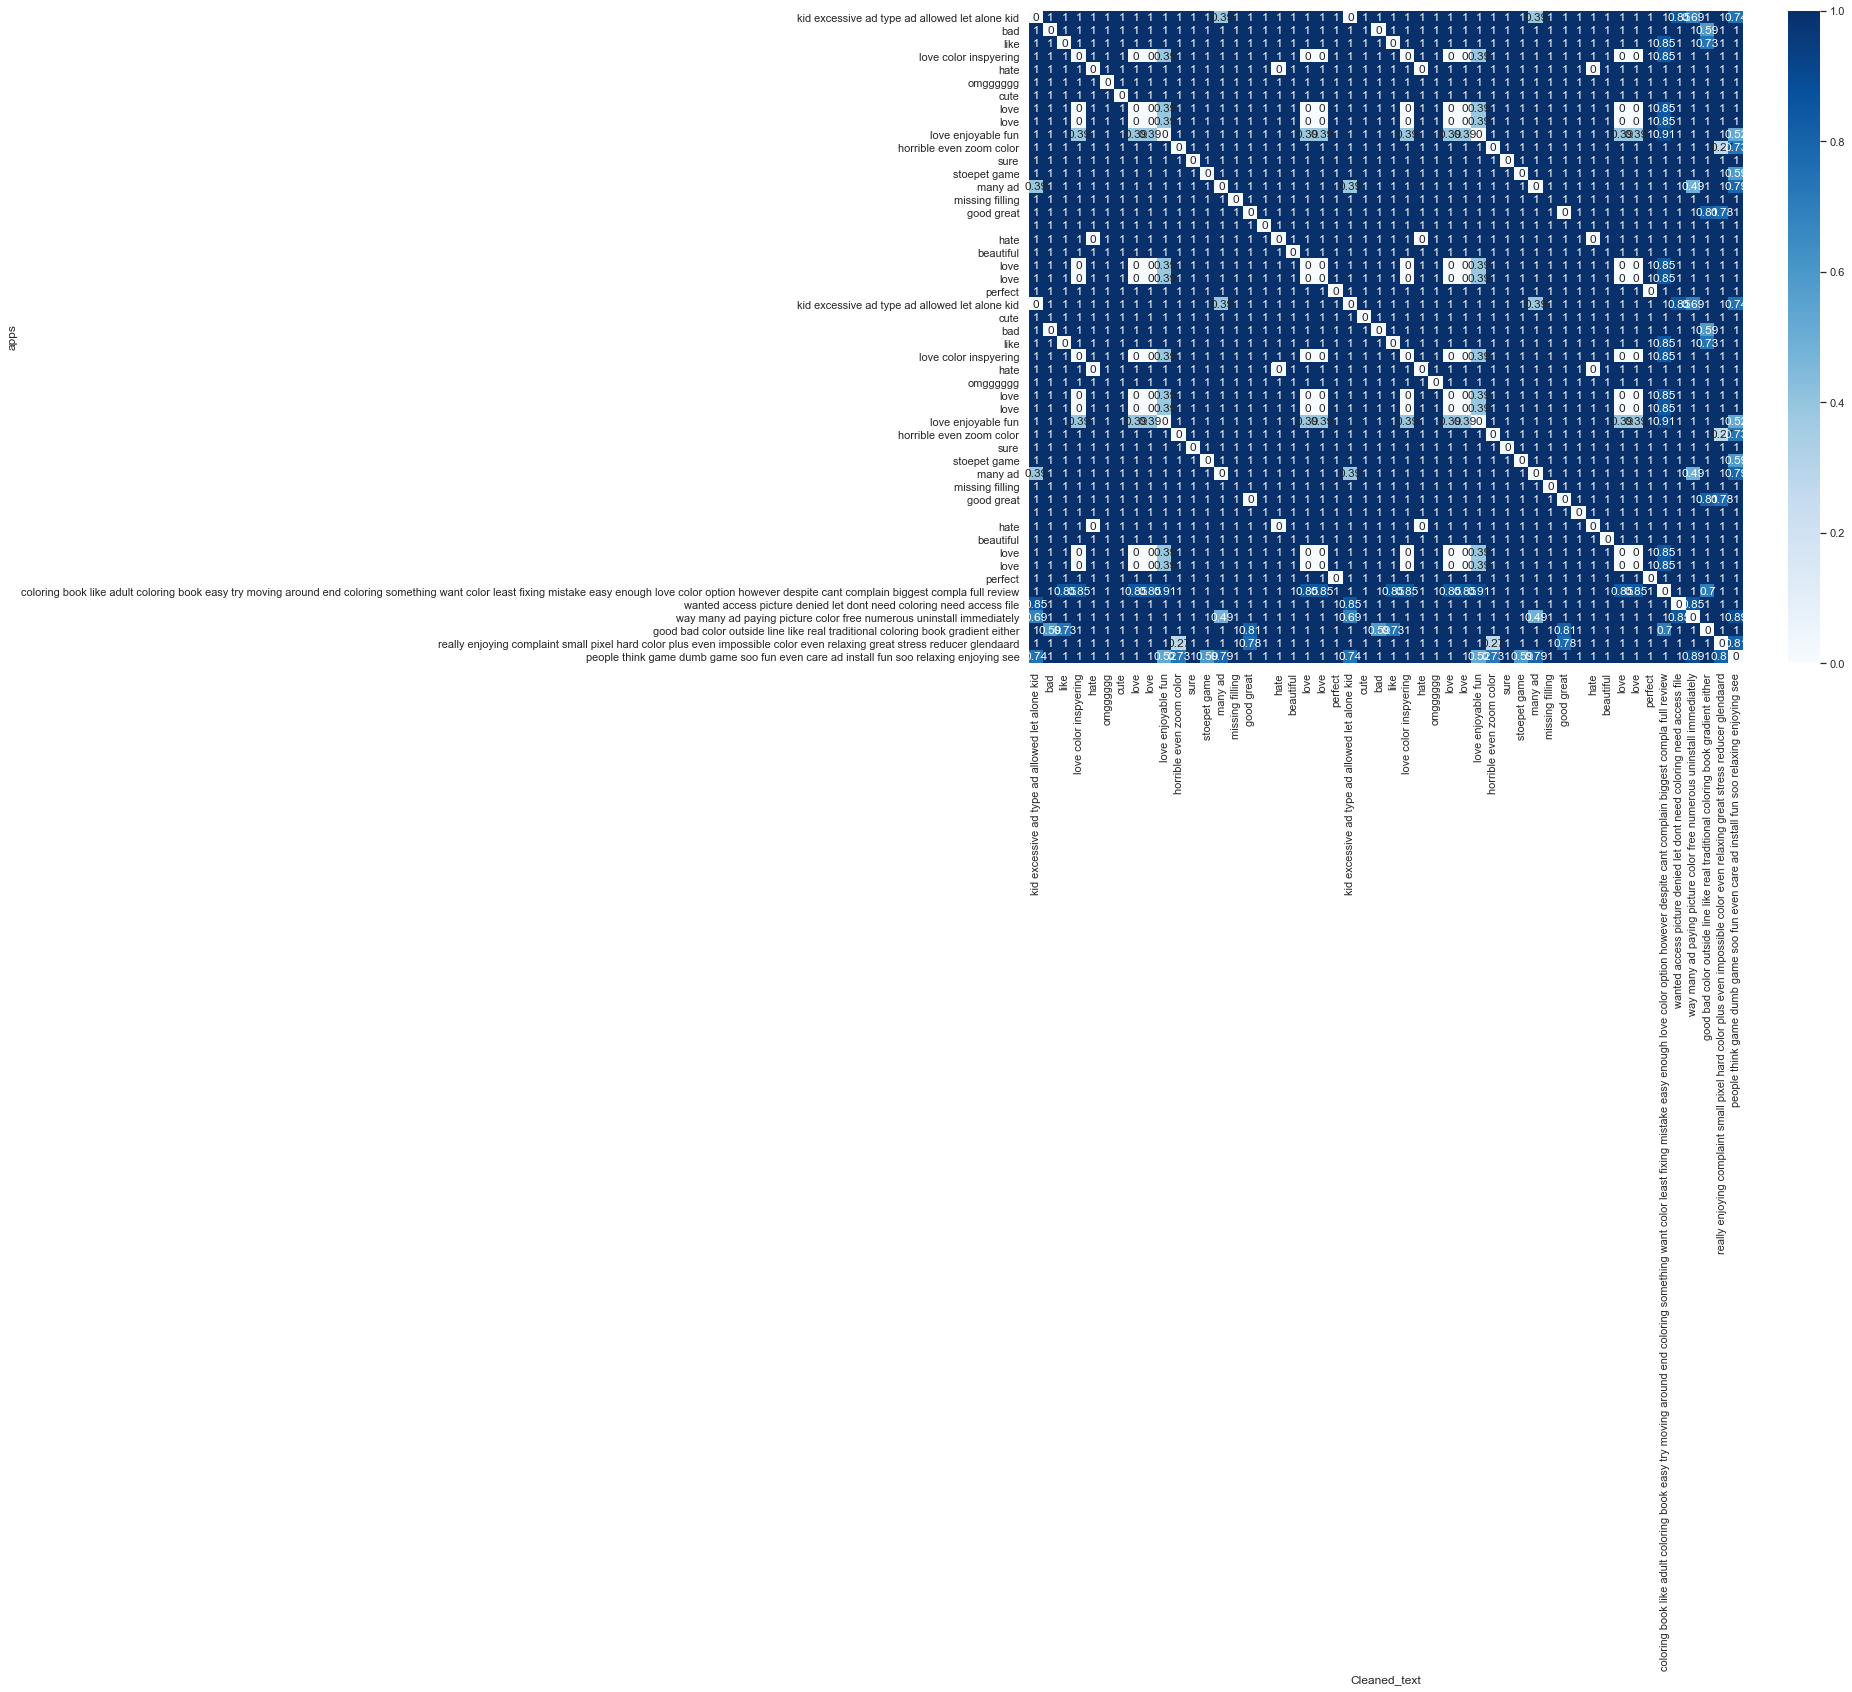

In [62]:
ut.afficheHeatmap(distance_cosine1,merged_df['Cleaned_text'].head(50))

#### Test avec distance Manhattan

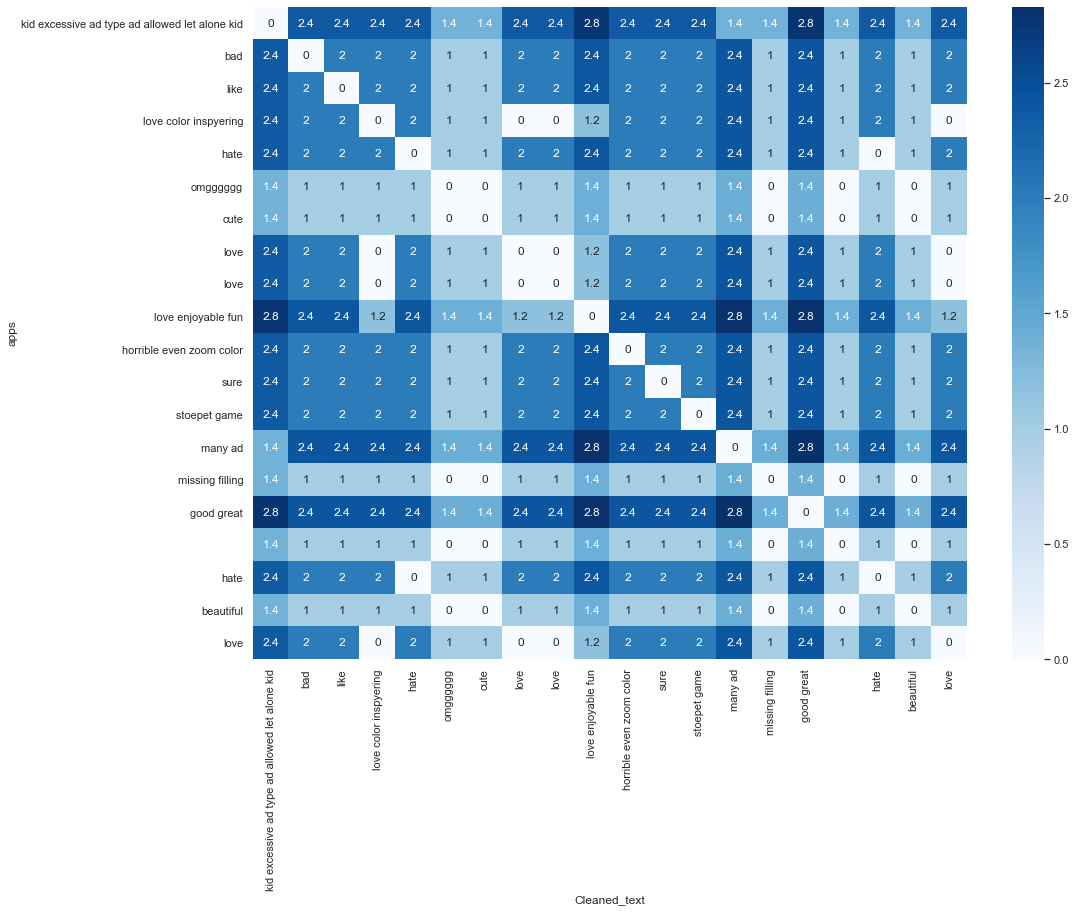

In [63]:
ut.afficheHeatmap(distance_manhattan,merged_df['Cleaned_text'].head(20))

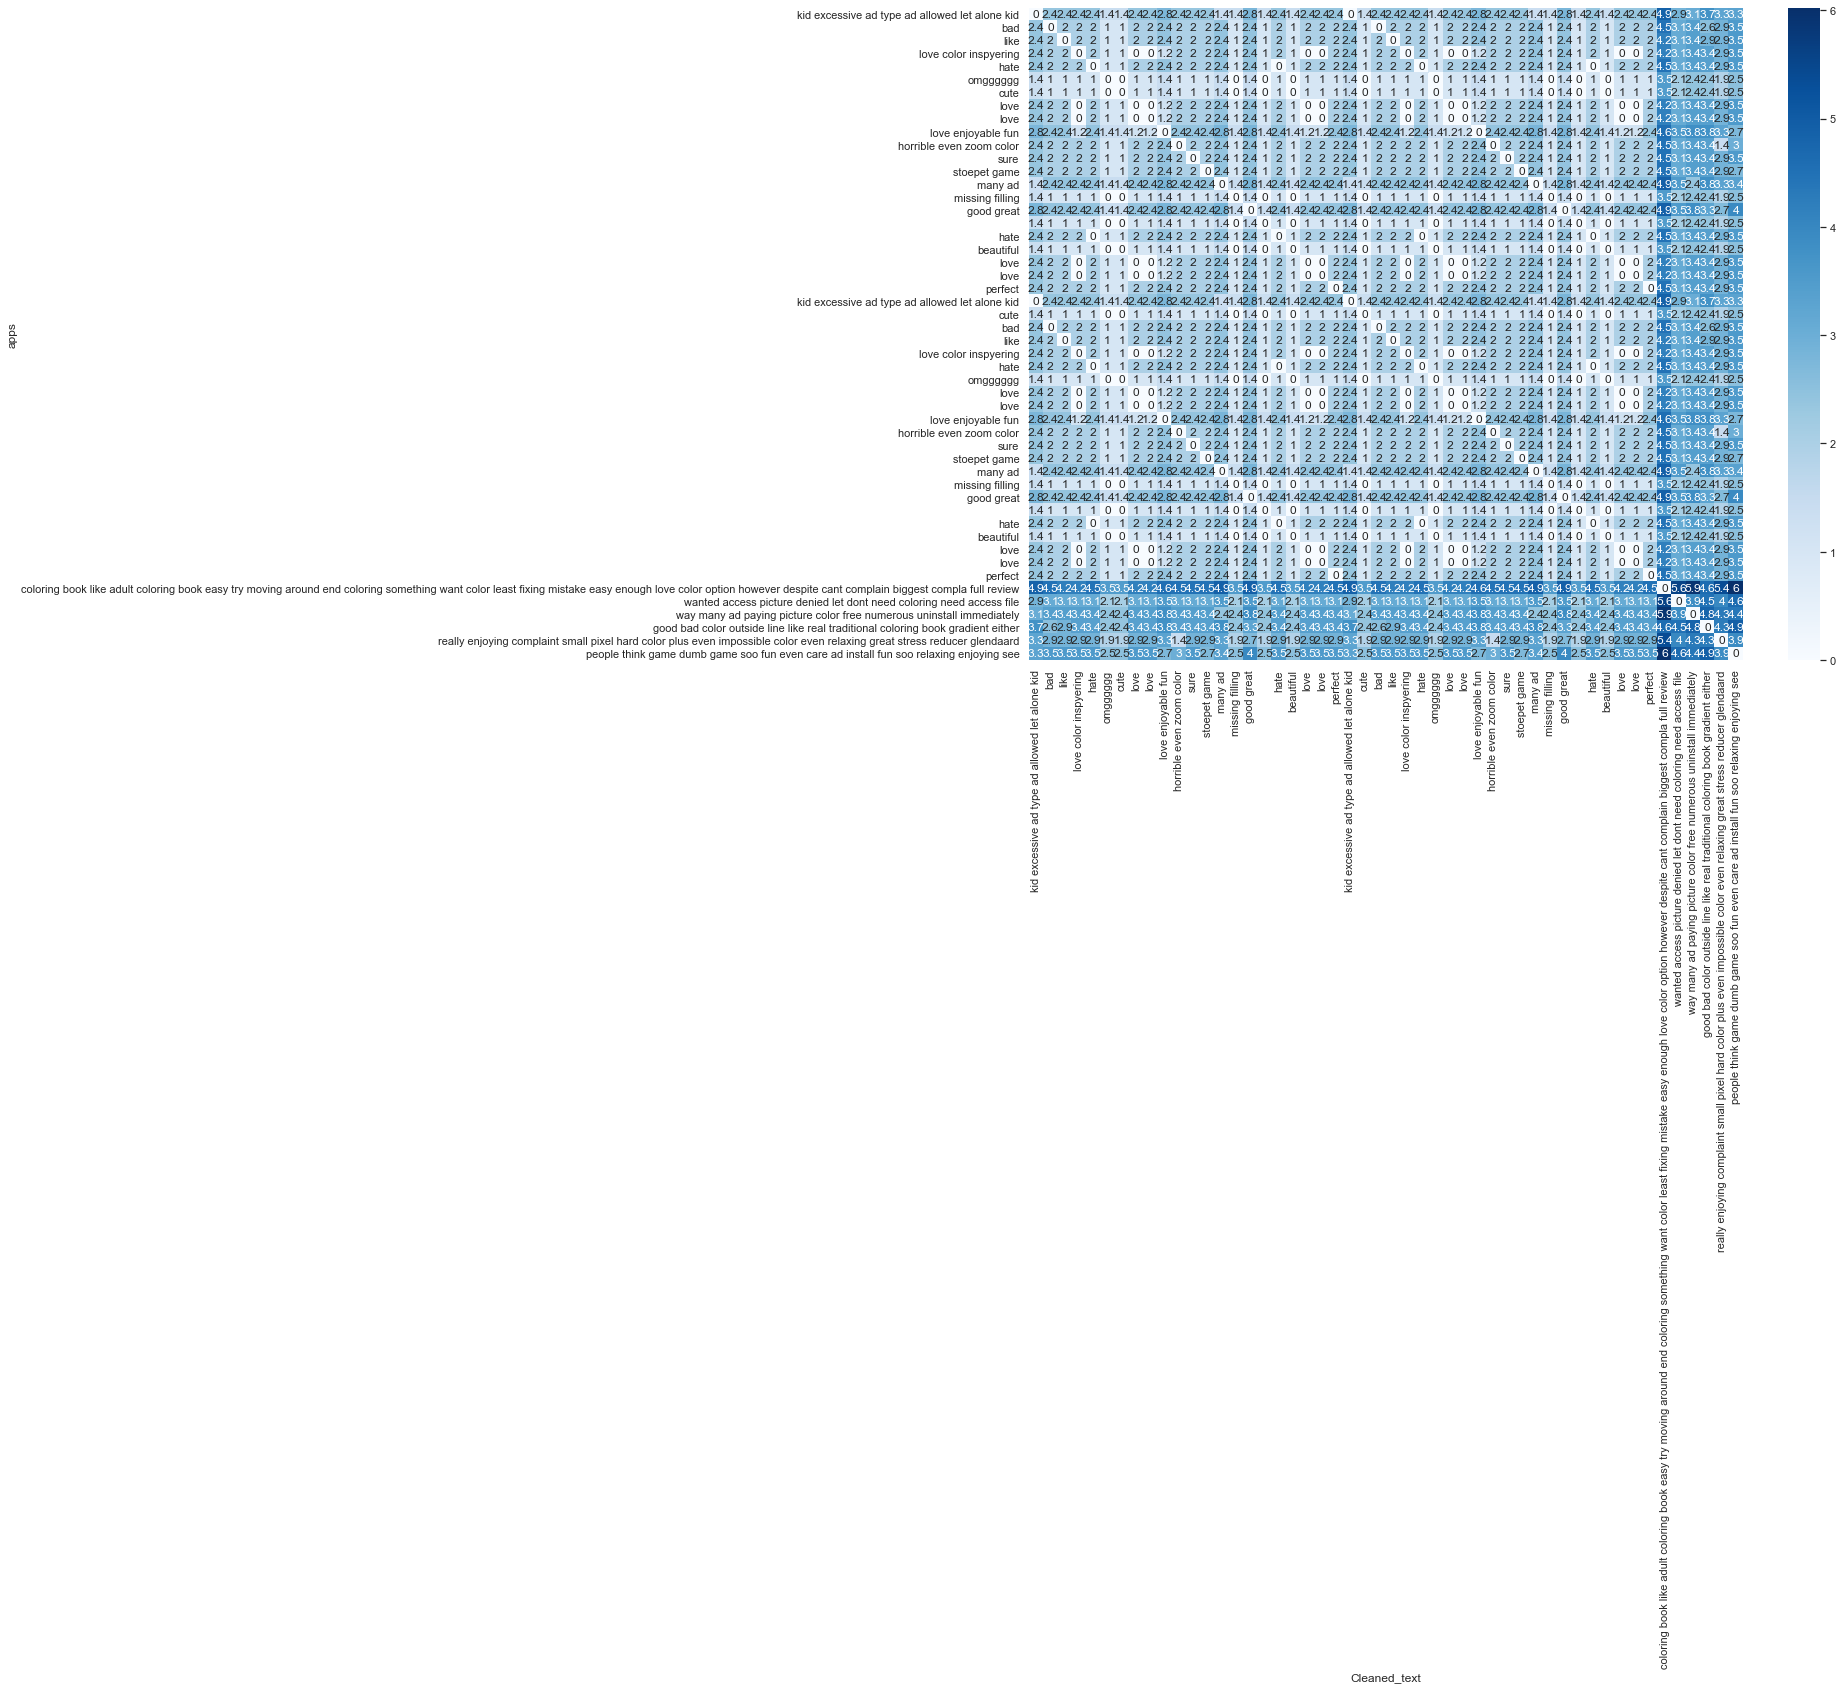

In [64]:
ut.afficheHeatmap(distance_manhattan1,merged_df['Cleaned_text'].head(50))

#### Test avec similarité cosayne

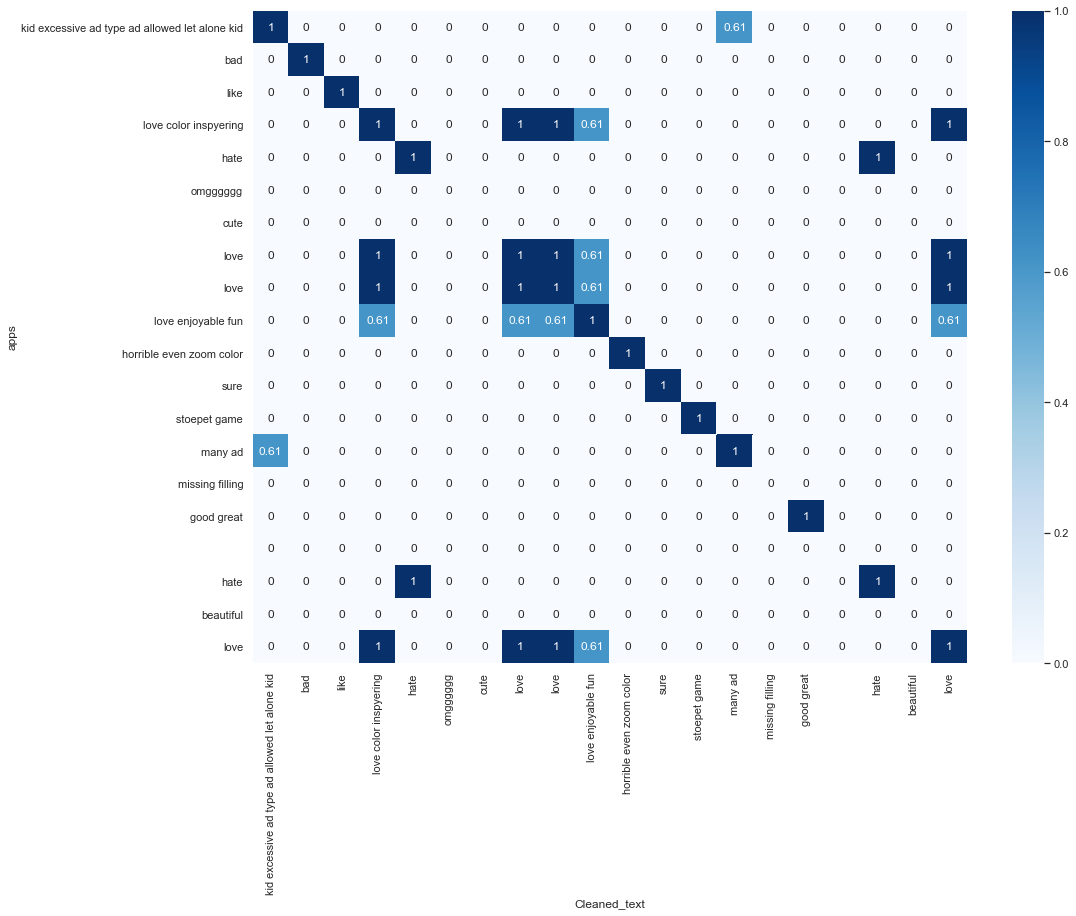

In [65]:
ut.afficheHeatmap(similariter_cosayne,merged_df['Cleaned_text'].head(20))

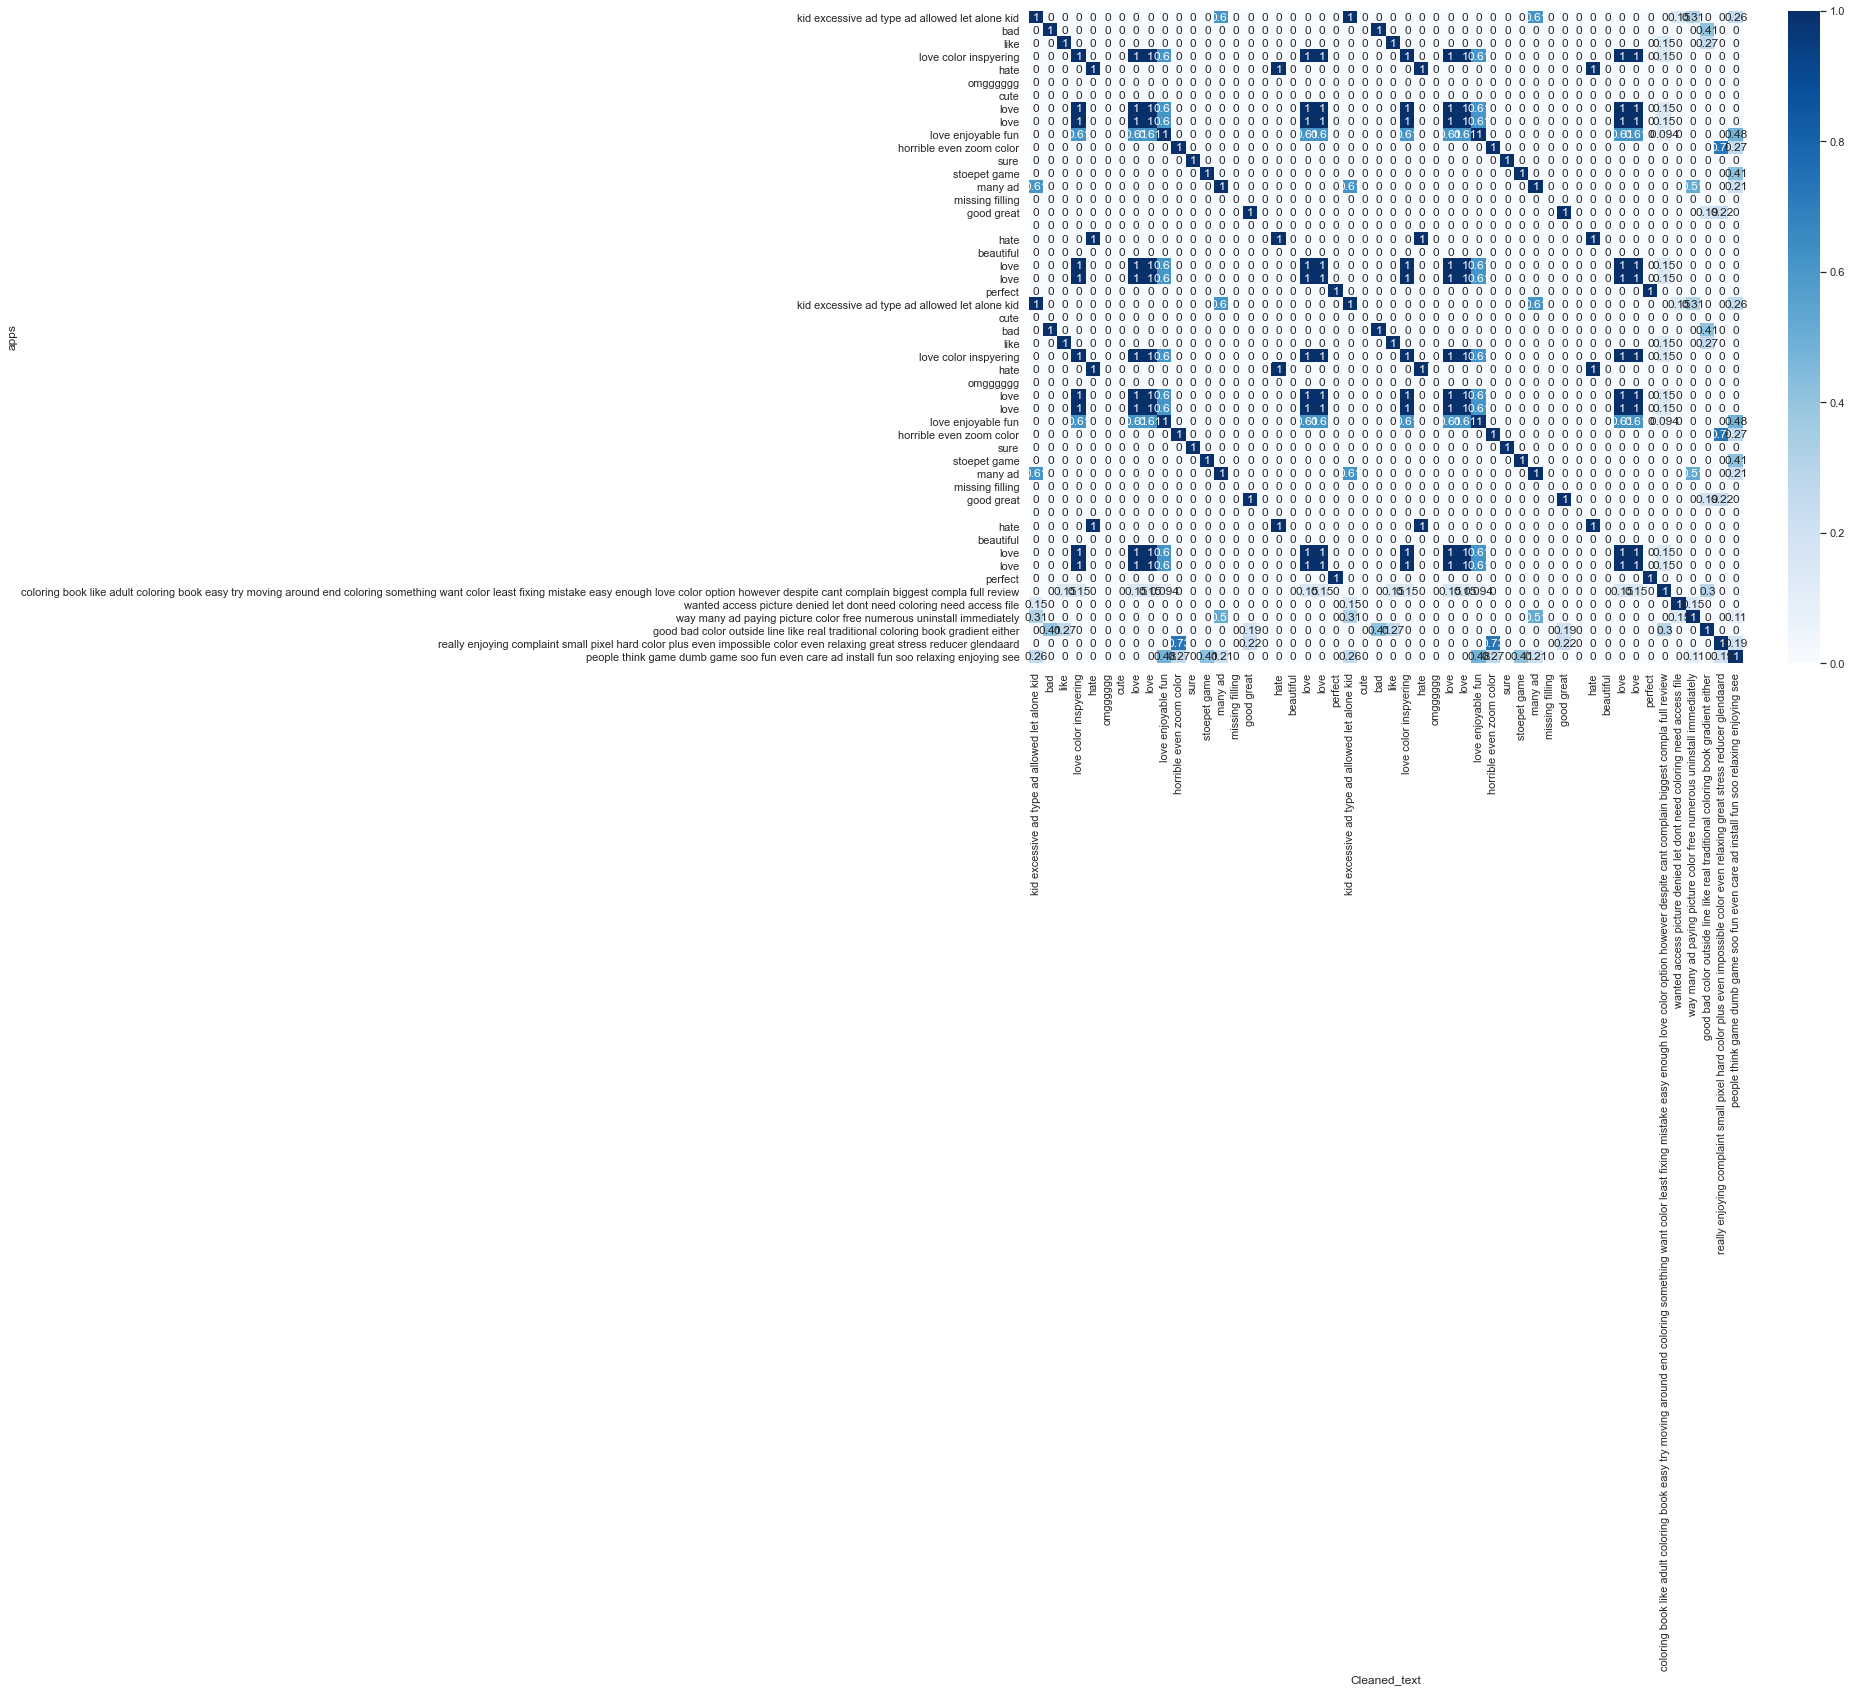

In [66]:
ut.afficheHeatmap(similariter_cosayne1,merged_df['Cleaned_text'].head(50))

#### K-MEANS

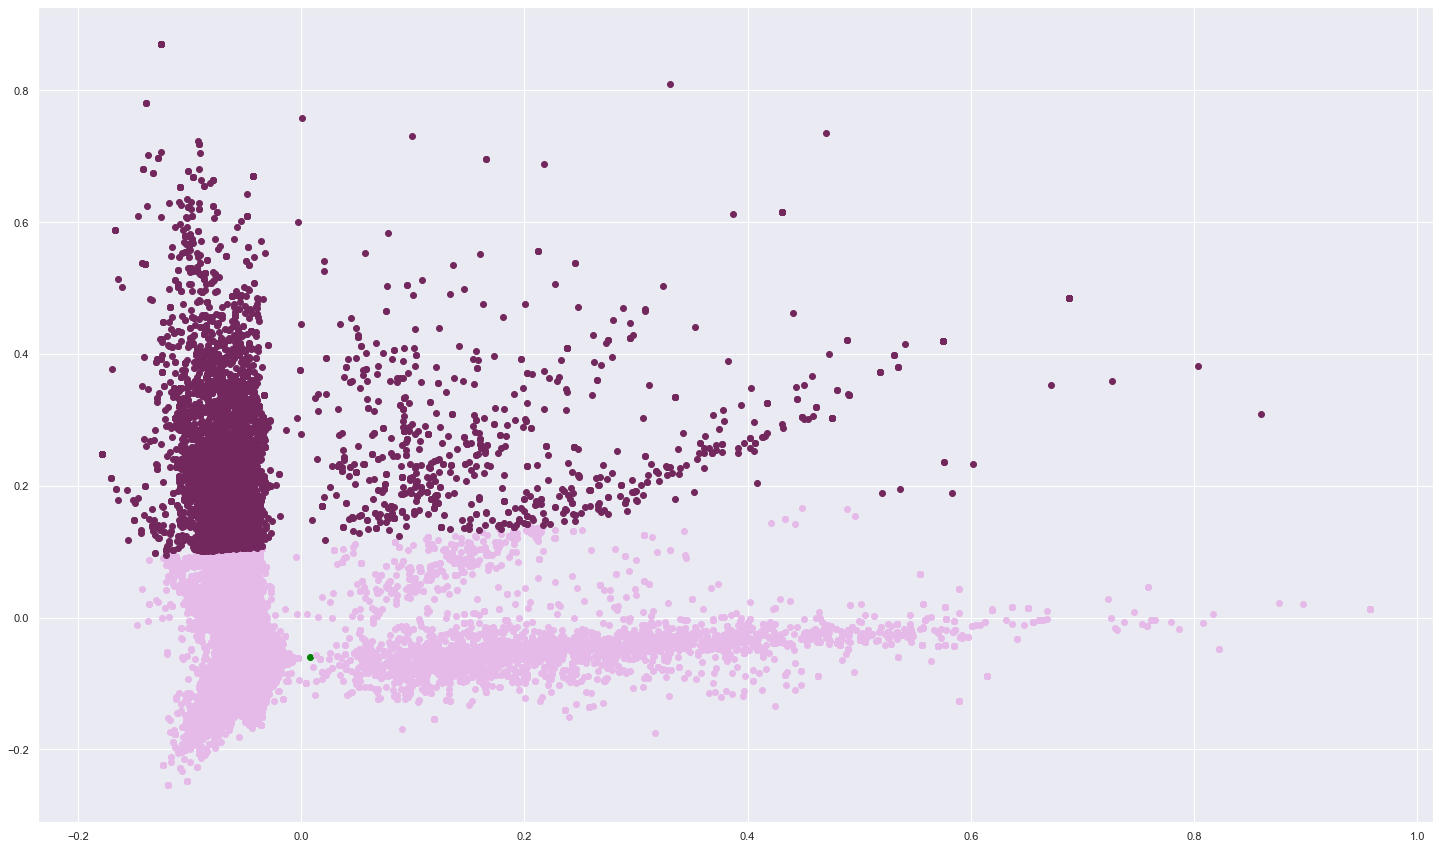

In [67]:
ut.affiche_resultat(dfkmeansA,les_centresA,l_affectationA)

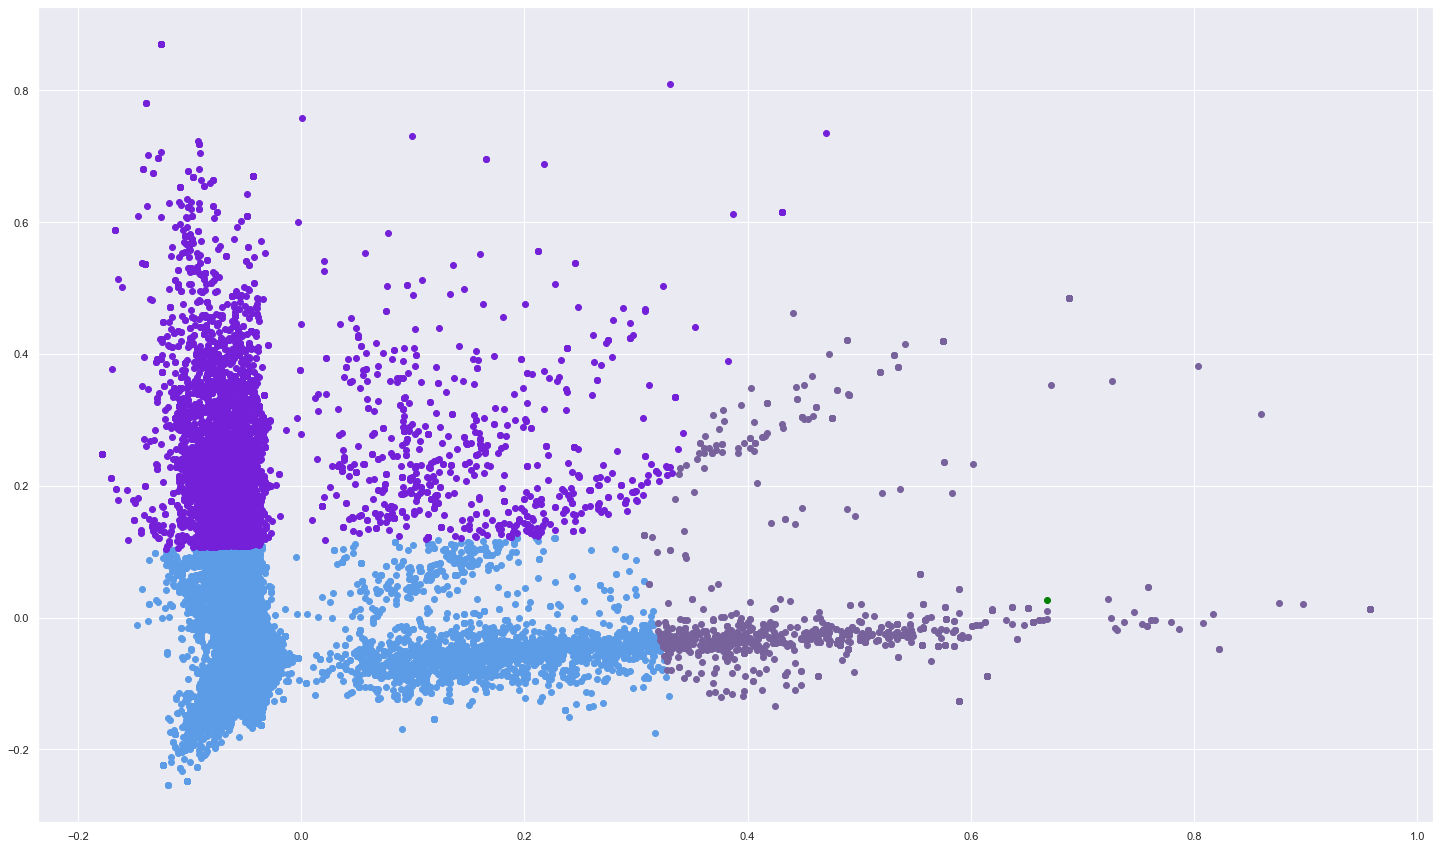

In [68]:
ut.affiche_resultat(dfkmeansA,les_centresA1,l_affectationA1)

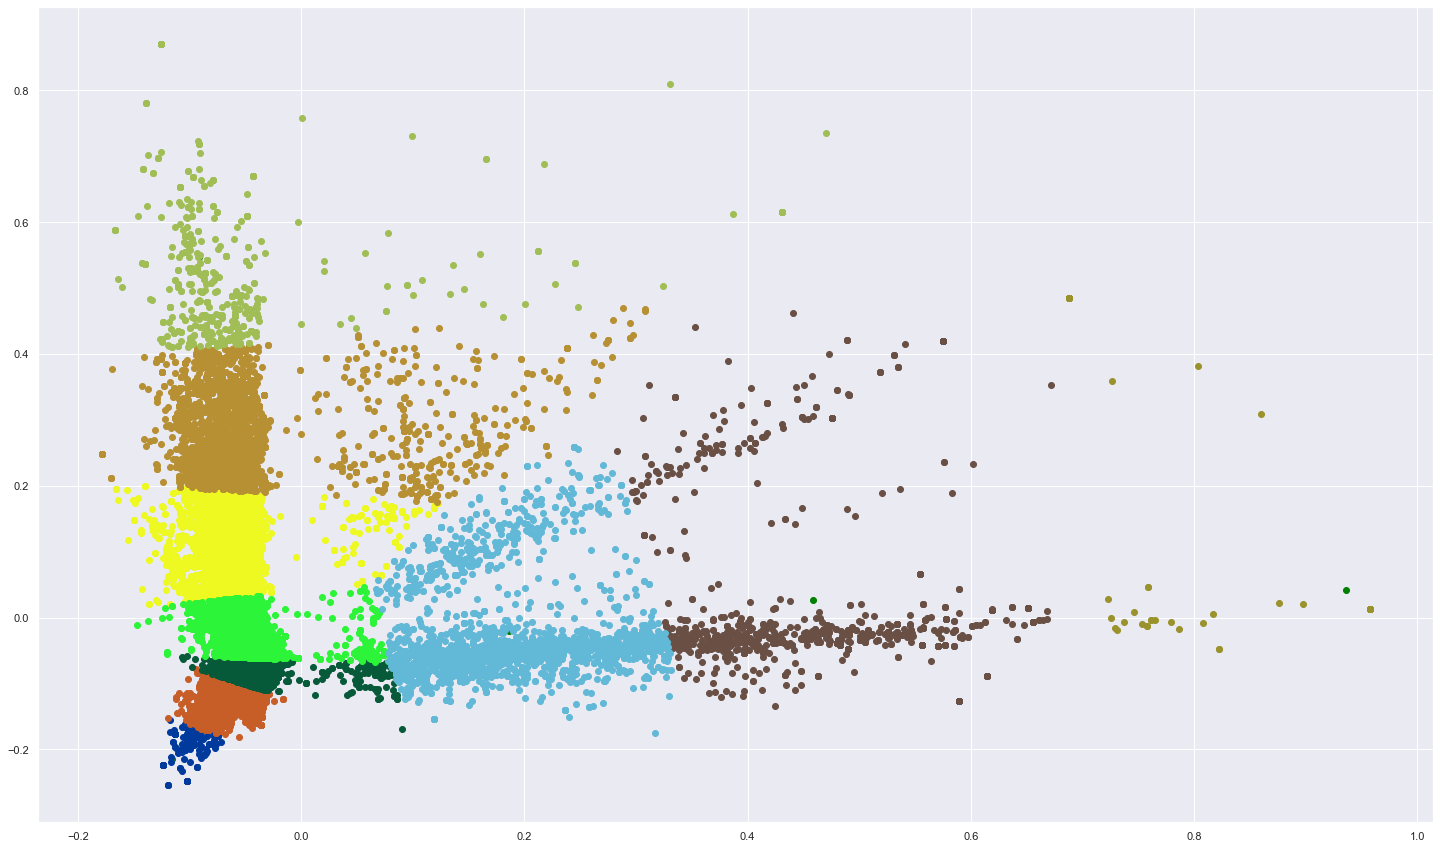

In [69]:
ut.affiche_resultat(dfkmeansA,les_centresA2,l_affectationA2)

### Sur les apps payantes

#### Clustering Hièrarchique

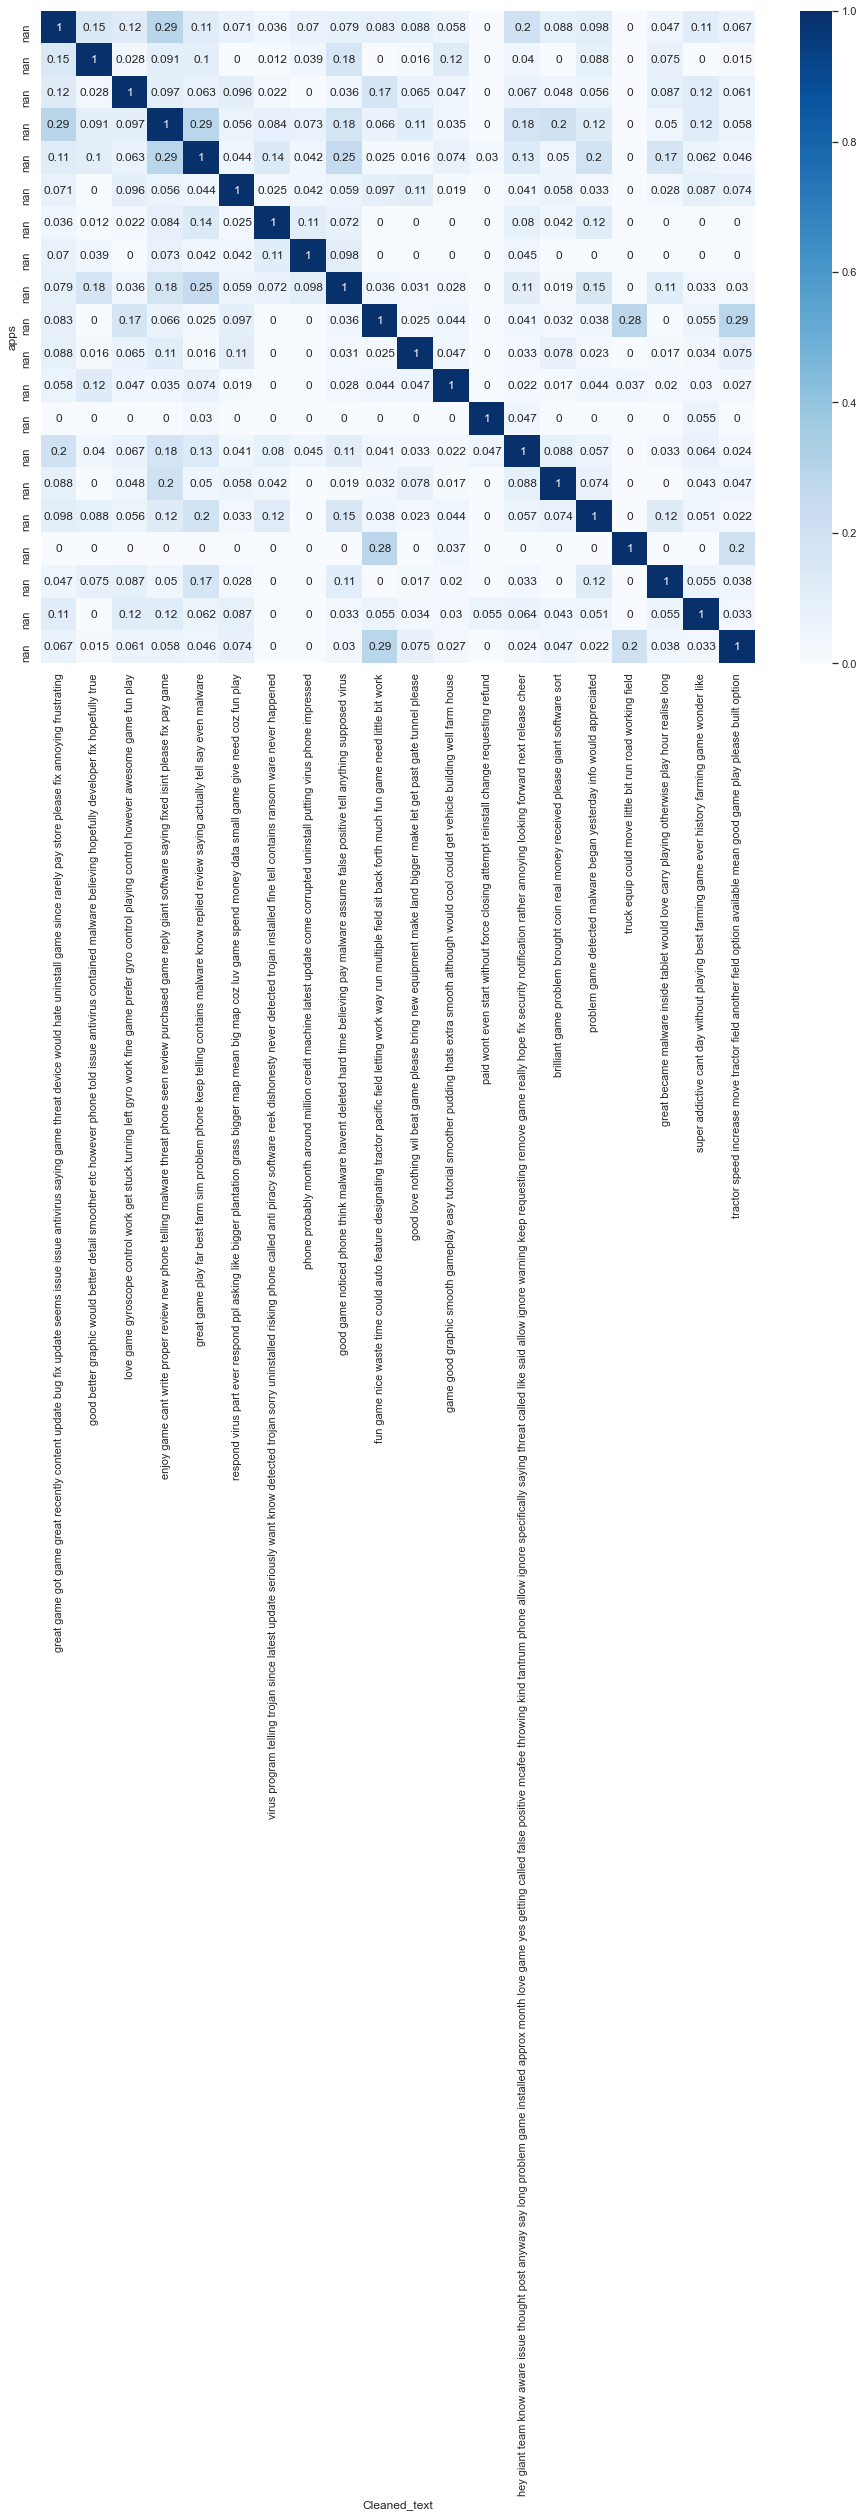

In [70]:
ut.afficheHeatmap(similariter_cosayneA,merged_df.loc[merged_df.Type=='Paid']['Cleaned_text'].head(20))

#### K-MEANS

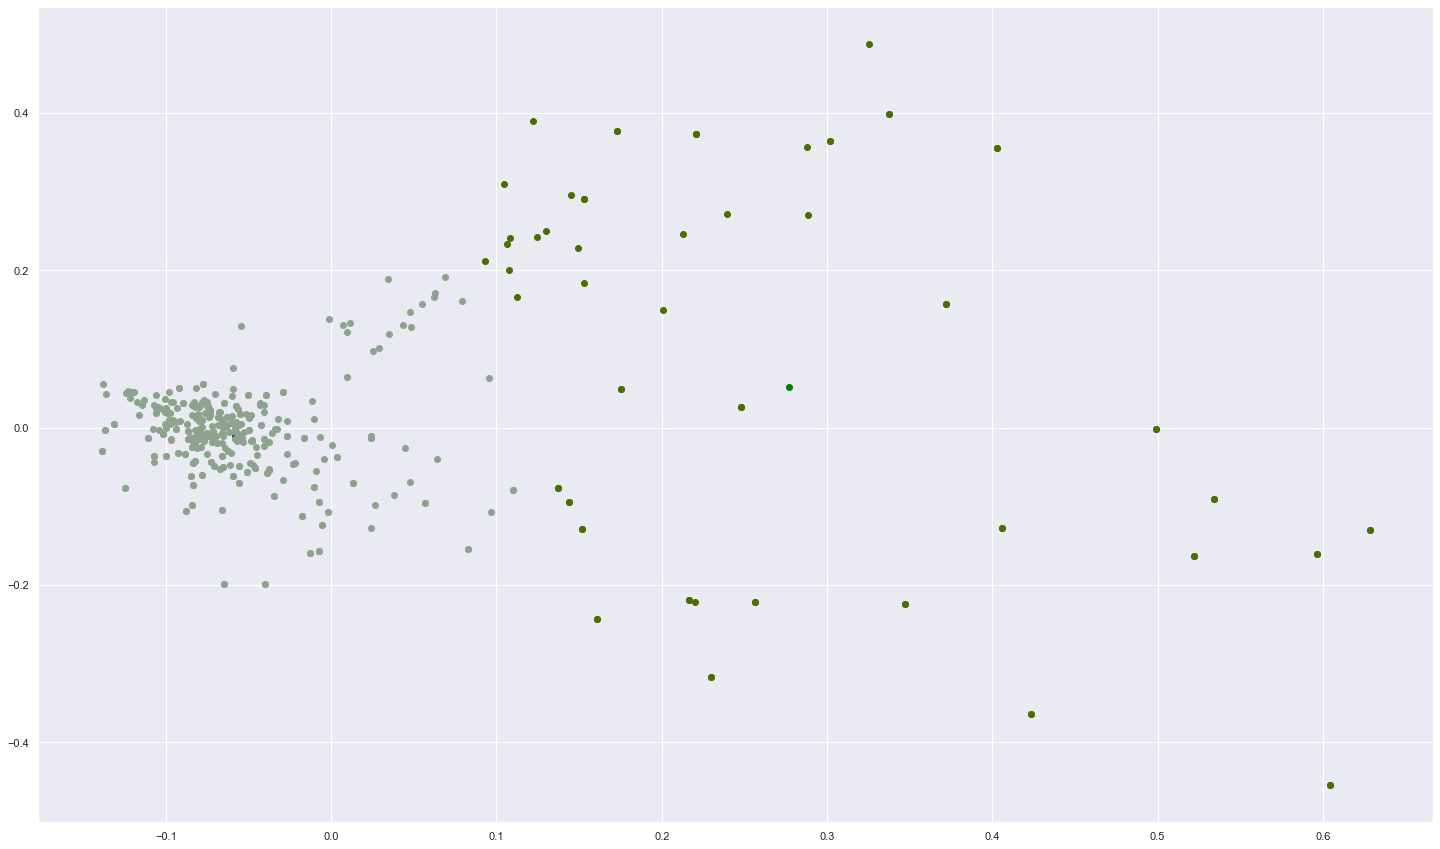

In [71]:
ut.affiche_resultat(dfkmeansB,les_centresB,l_affectationB)

In [72]:
pwc=wc1.words_.keys()

In [73]:
print(pwc)

dict_keys(['game', 'great', 'better', 'love', 'deal', 'got', 'recently', 'content', 'upd', 'good', 'graphic', 'detail', 'smooth', 'gyroscope', 'control', 'work', 'stuck', 'tur', 'enjoy', 'cant', 'write', 'proper', 'review', 'new', 'phone', 'play', 'far', 'best', 'farm', 'sim', 'problem', 'phon', 'amazing', 'thanks', 'developer', 'wonderful', 'superb', 'awesome', 'easy', 'simple', 'black', 'friday', 'sonny', 'waiting', 'mother', 'th', 'cheap', 'extremely', 'well', 'done', 'free', 'kennedy', 'theme', 'g', 'Name', 'Cleaned_text', 'Length', 'dtype', 'object'])


In [74]:
pwc=['game', 'great', 'better', 'love','malware','problem','deal', 'got', 'recently', 'content', 'good', 'graphic', 'detail', 'smooth', 'gyroscope', 'control', 'work', 'stuck', 'enjoy', 'cant', 'write', 'proper', 'review', 'new', 'phone', 'play', 'far', 'best', 'farm', 'sim', 'problem', 'amazing', 'thanks', 'developer', 'wonderful', 'superb', 'awesome', 'easy', 'simple', 'black', 'friday', 'sonny', 'waiting', 'mother', 'cheap', 'extremely', 'well', 'done', 'free', 'kennedy', 'theme']
pwc = [e for e in pwc if e not in ('cheap', 'black', 'proper', 'farm', 'superb', 'enjoy', 'write', 'sonny', 'mother', 'sim', 'friday', 'detail', 'deal', 'kennedy', 'gyroscope', 'smooth')]

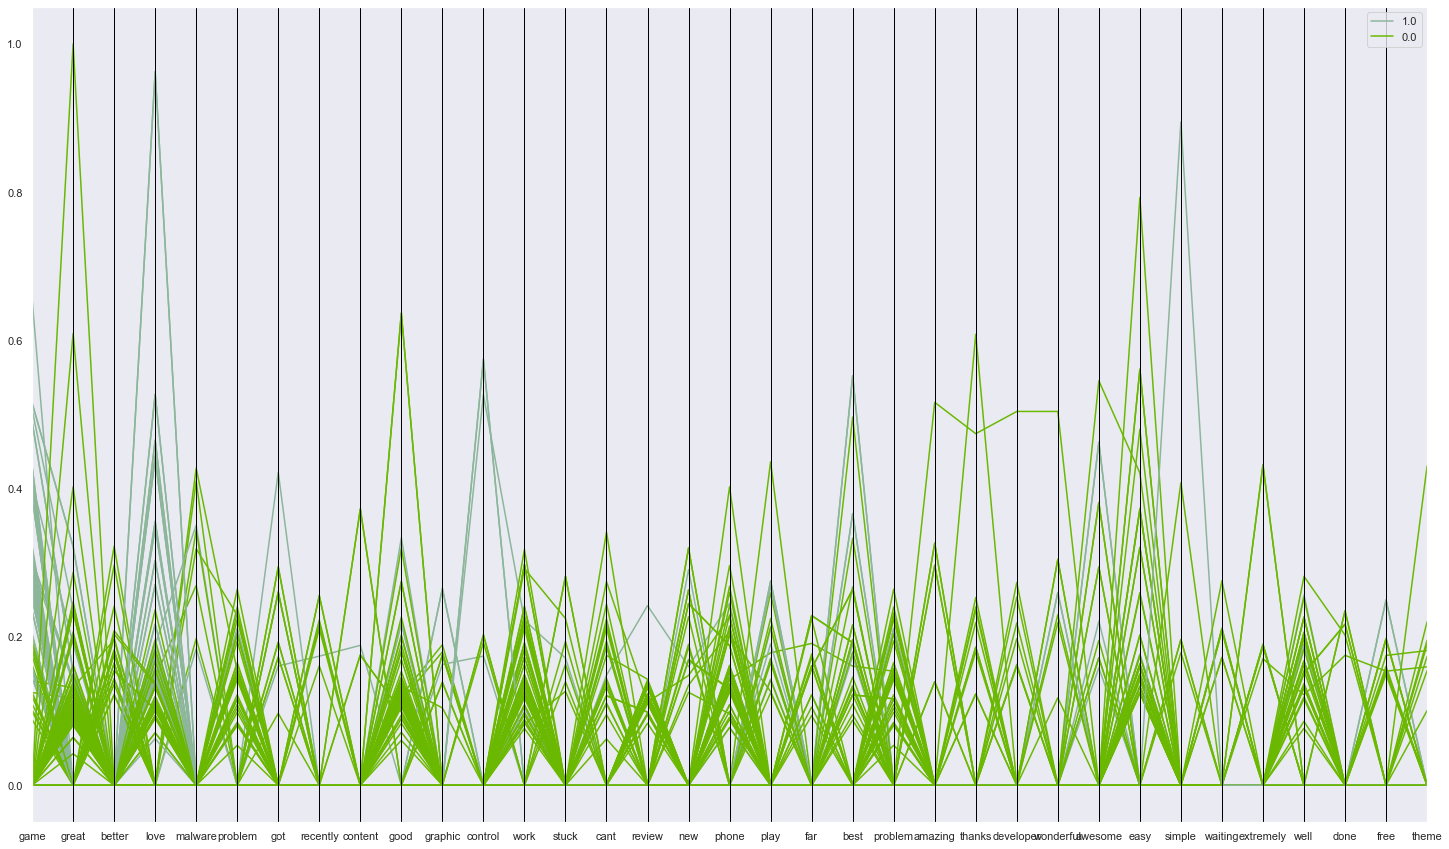

In [75]:
ut.interpret_kmeans(l_affectationB,pd_tfidf1,pwc)

### Sur les apps gratuites

#### Clustering Hièrarchique

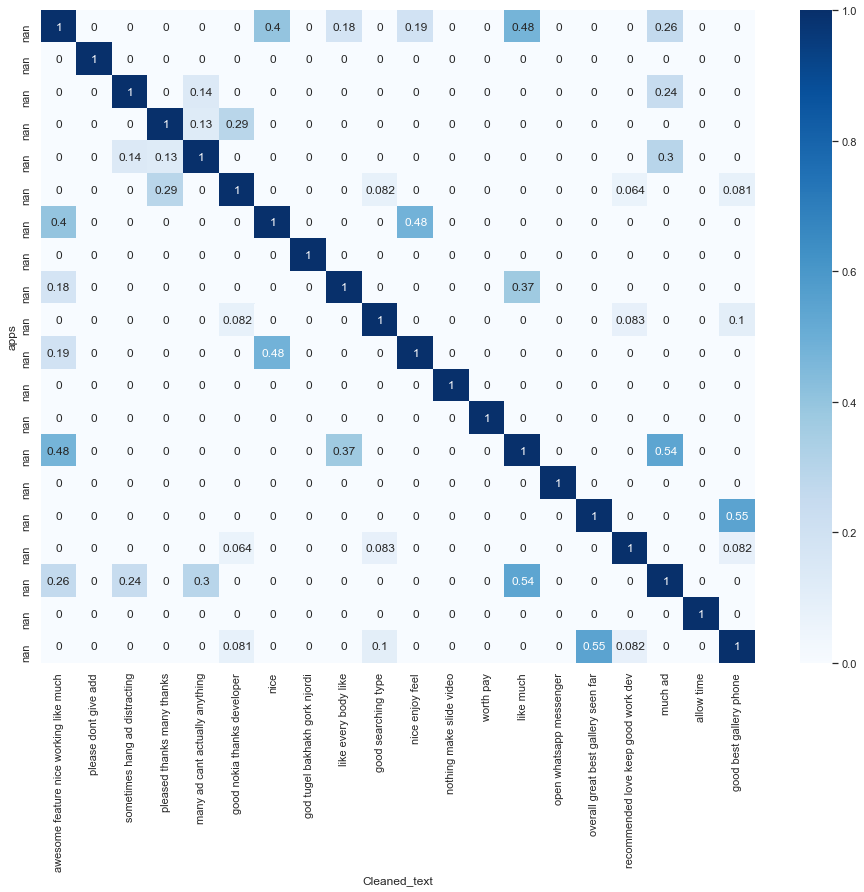

In [76]:
ut.afficheHeatmap(similariter_cosayneB,merged_df.loc[merged_df.Type=='Free']['Cleaned_text'].tail(20))

#### K-MEANS

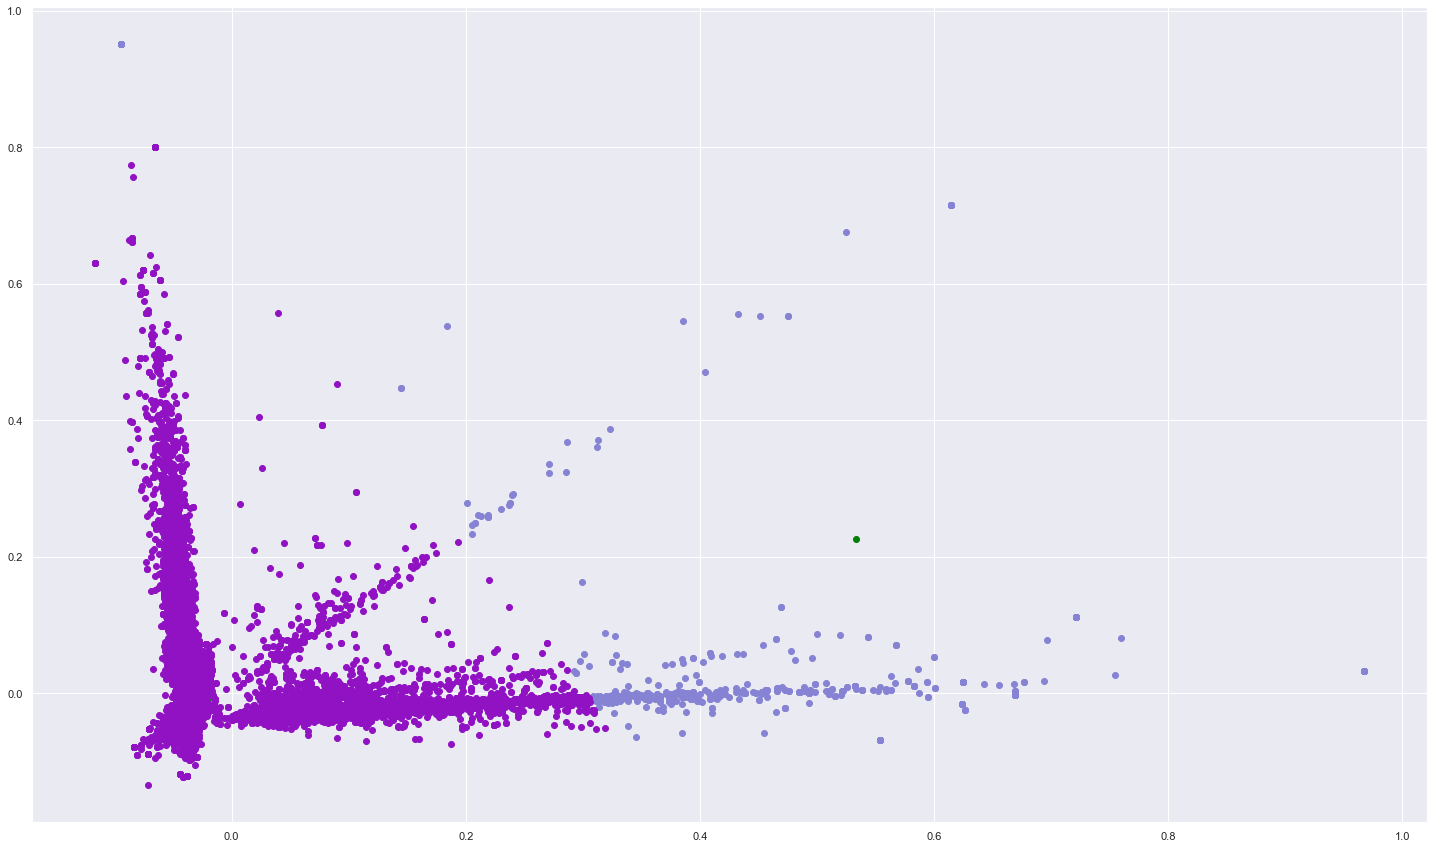

In [77]:
ut.affiche_resultat(dfkmeansC,les_centresC,l_affectationC)

In [78]:
fwc=wc.words_.keys()
print(fwc)

dict_keys(['ad', 'kid', 'love', 'best', 'gallery', 'good', 'excessive', 'type', 'allowed', 'let', 'alone', 'bad', 'color', 'inspyering', 'hate', 'overall', 'great', 'seen', 'far', 'recommended', 'keep', 'work', 'dev', 'much', 'allow', 'time', 'phone', 'Name', 'Cleaned_text', 'Length', 'dtype', 'object'])


In [79]:
fwc=['ad', 'kid', 'gallery', 'excessive', 'allowed', 'let', 'alone', 'bad', 'color', 'inspyering', 'hate', 'overall', 'great', 'seen', 'far', 'recommended', 'keep', 'work', 'much', 'allow', 'time', 'phone']

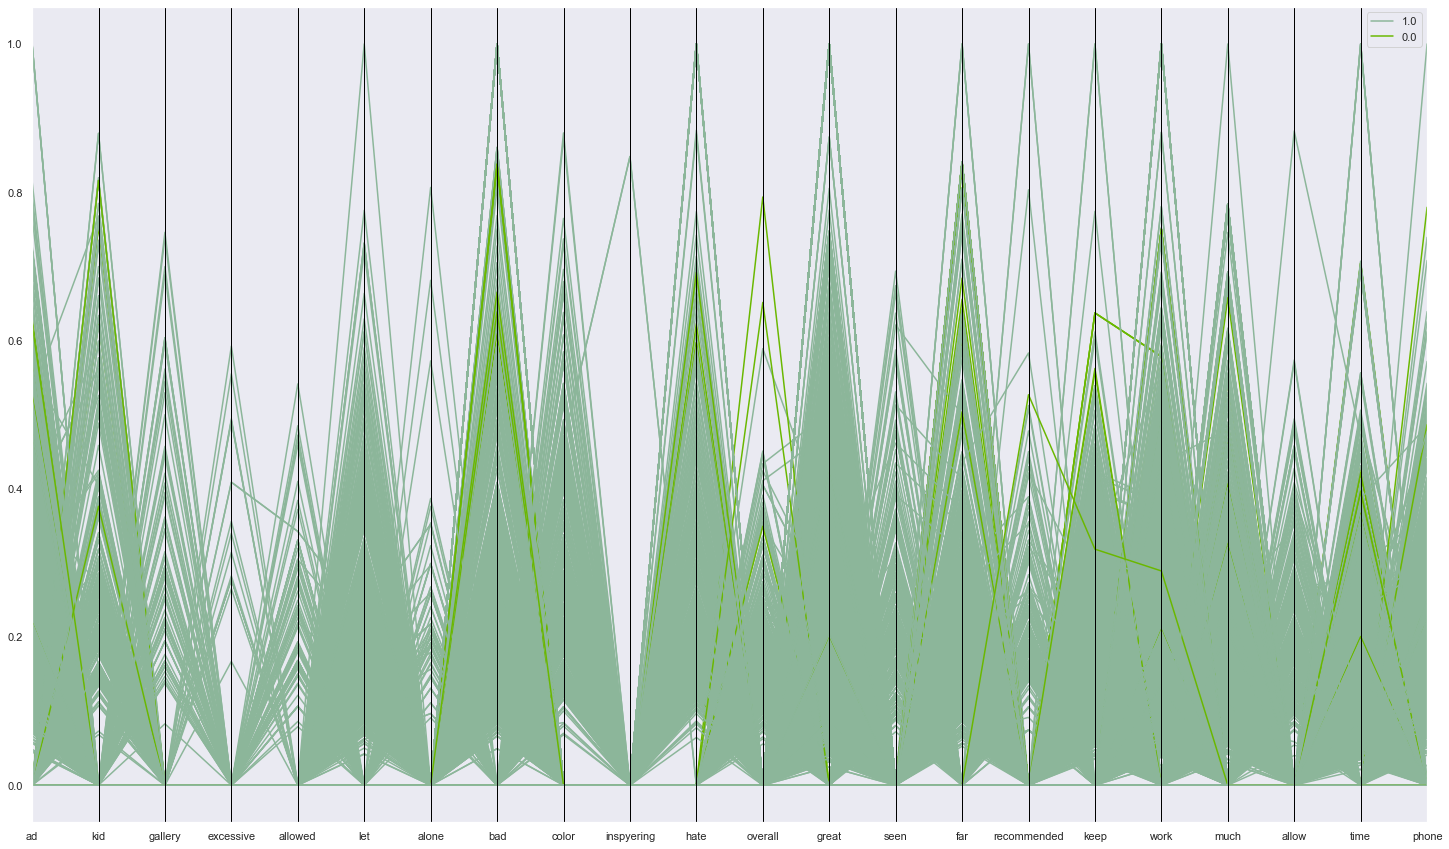

In [80]:
ut.interpret_kmeans(l_affectationC,pd_tfidf2,fwc)

## Partie 6 - Analyse



#### En regardant les résultats, nous remarquons instantanément que les applications gratuites sont critiqué beaucoup plus sévèrement que les applications payantes.
#### Une autre manière de résoudre ce problème est de faire d'abord de trouver le k de kmeans en suivant Dunn ou Elbow Method, ensuite on lance le kmeans pour obtenir les centroides et les utilisé pour créer des clustering hiérarchique dendrogramme.

#### Conclusion : Résolution de problématique réussit. Effectivement, la manière dont les utilisateurs critiquent les apps varie largement des apps gratuites au apps payantes.